## Análisis del laboratorio de masa

In [29]:
import pandas as pd
import numpy as np

In [30]:
# Import custom libraries
import warnings
import sys
import os

# Subir dos niveles desde notebooks/mod_tecnico/ hasta la raíz del repo
repo_path = os.path.abspath(os.path.join(os.getcwd(), "../.."))  
sys.path.append(repo_path)

# Ahora intenta importar
from src.data_processing import ready_to_import

In [31]:
#Importar librerias para graficar
from matplotlib import pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
import plotly.figure_factory as ff
from plotly.subplots  import make_subplots

In [32]:
# Importamos lo necesario para trabajar con consultas SQL

from pandasql import sqldf

# Definir función de consulta
pysqldf = lambda q: sqldf(q, globals())

#### Se carga el dataset 

In [33]:
# Import data from Excel files
url = "https://raw.githubusercontent.com/MiguelOscar-Insco/data-INSCO-hub/main/data/raw/masa_25.xlsx"
masa = pd.read_excel(url)


In [34]:
# Resumen estadístico de la tabla
masa.describe()

,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,piece_count
count,460,453,473,474,479,479.000000,479.000000,479.000000
mean,2025-01-30 03:01:33.913043456,2025-02-18 19:23:26.622516480,2025-01-31 02:23:05.200845568,2025-02-09 19:11:23.544303616,2025-02-15 05:24:40.584551168,8.630480,12.283925,5.102296
min,2024-11-06 00:00:00,2024-12-19 00:00:00,2024-03-12 00:00:00,2024-03-13 00:00:00,2025-01-02 00:00:00,0.000000,0.000000,1.000000
25%,2025-01-14 00:00:00,2025-01-31 00:00:00,2025-01-13 00:00:00,2025-01-23 00:00:00,2025-01-24 00:00:00,5.000000,11.000000,1.000000
50%,2025-01-28 00:00:00,2025-02-18 00:00:00,2025-01-29 00:00:00,2025-02-10 00:00:00,2025-02-11 00:00:00,8.000000,12.000000,1.000000
75%,2025-02-25 00:00:00,2025-03-13 00:00:00,2025-02-28 00:00:00,2025-03-09 06:00:00,2025-03-11 00:00:00,11.000000,15.000000,3.000000
max,2025-03-27 00:00:00,2025-04-04 00:00:00,2025-03-28 00:00:00,2025-03-31 00:00:00,2025-03-31 00:00:00,44.000000,30.000000,58.000000
std,NaN,NaN,NaN,NaN,NaN,5.928019,5.245318,8.710834


In [35]:
# Seleccionamos las columnas que contienen fechas y las convertimos a tipo datetime
col_fechas = [col for col in masa.columns if 'date' in col.lower() or 'fecha' in col.lower()]

for col in col_fechas:
    masa[col] = pd.to_datetime(masa[col], errors='coerce', format='%Y/%m/%d')

In [36]:
masa.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585 entries, 0 to 584
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            460 non-null    object        
 1   so                       479 non-null    object        
 2   assignee                 585 non-null    object        
 3   calibrator               479 non-null    object        
 4   supervisor               479 non-null    object        
 5   approver                 479 non-null    object        
 6   classification           479 non-null    object        
 7   lab_received_date        460 non-null    datetime64[ns]
 8   scheduled_delivery_date  453 non-null    datetime64[ns]
 9   cleaning_date            473 non-null    datetime64[ns]
 10  calibration_date         474 non-null    datetime64[ns]
 11  delivery_date            479 non-null    datetime64[ns]
 12  delivery_time            479 non-nul

In [37]:
# Se hace una copia de la tabla para evitar problemas de referencia
mass = masa.copy()

**Se eliminan las filas donde 'report_number' es NaN y se une el contenido de 'assignee' de las filas con 'report_number' NaN a la fila anterior**

In [38]:
# Esta función es interna y creada para el proceso en el que se va a usar
mass = ready_to_import.to_prepare_db(mass)
# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 20 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            460 non-null    object        
 1   so                       460 non-null    object        
 2   assignee                 460 non-null    object        
 3   calibrator               460 non-null    object        
 4   supervisor               460 non-null    object        
 5   approver                 460 non-null    object        
 6   classification           460 non-null    object        
 7   lab_received_date        460 non-null    datetime64[ns]
 8   scheduled_delivery_date  453 non-null    datetime64[ns]
 9   cleaning_date            454 non-null    datetime64[ns]
 10  calibration_date         455 non-null    datetime64[ns]
 11  delivery_date            460 non-null    datetime64[ns]
 12  delivery_time            460 non-nul

## Agregamos columnas temporales segmentadas

In [39]:
# Crear columnas derivadas de la fecha de recepción
mass['year_received'] = mass['lab_received_date'].dt.year
mass['month_received'] = mass['lab_received_date'].dt.month
mass['week_received'] = mass['lab_received_date'].dt.isocalendar().week

# Crear columnas derivadas de la fecha de entrega
mass['year_delivery'] = mass['delivery_date'].dt.year
mass['month_delivery'] = mass['delivery_date'].dt.month
mass['week_delivery'] = mass['delivery_date'].dt.isocalendar().week

In [40]:
approver = pysqldf("""
SELECT report_number, COUNT(report_number) AS count
FROM mass
GROUP BY report_number
HAVING COUNT(report_number) > 1
""")
approver

,report_number,count
0,CCM0014.M/2025,2
1,CCM0015.M/2025,2
2,CCM0016.M/2025,2
3,CCM0042.M/2025,2
4,CCM0045.M/2025,3
5,CCM0061.M/2025,5
6,CCM0089.M/2025,2
7,CCM0090.M/2025,2
8,CCM0138.M/2025,2
9,CCM0167.M/2025,2


In [41]:
mass.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 460 entries, 0 to 459
Data columns (total 26 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            460 non-null    object        
 1   so                       460 non-null    object        
 2   assignee                 460 non-null    object        
 3   calibrator               460 non-null    object        
 4   supervisor               460 non-null    object        
 5   approver                 460 non-null    object        
 6   classification           460 non-null    object        
 7   lab_received_date        460 non-null    datetime64[ns]
 8   scheduled_delivery_date  453 non-null    datetime64[ns]
 9   cleaning_date            454 non-null    datetime64[ns]
 10  calibration_date         455 non-null    datetime64[ns]
 11  delivery_date            460 non-null    datetime64[ns]
 12  delivery_time            460 non-nul

### Comparamos la cantidad de calibraciones con los mantenimientos

In [42]:
# Clasificar por tipo de servicio
mass['service_type'] = np.where(
    mass['report_number'].str.startswith('RSM', na=False),
    'Mantenimiento',
    np.where(
        mass['report_number'].str.startswith('CCM', na=False),
        'Calibración',
        'Otros'  # Valor por defecto si ninguna condición se cumple
    )
)

#### Mostramos un dataset con los tipos de servicio

In [43]:
no_errors = mass[mass['substitution_reason'].isnull()]
no_errors.head(10)

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,...,lab_observations,priority,piece_count,year_received,month_received,week_received,year_delivery,month_delivery,week_delivery,service_type
0,CCM0001.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,NaN,ORDINARIO,1.0,2024,12,49,2025,1,2,Calibración
1,CCM0002.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,NaN,ORDINARIO,1.0,2024,12,49,2025,1,2,Calibración
2,CCM0003.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,NaN,ORDINARIO,1.0,2024,12,49,2025,1,2,Calibración
3,CCM0004.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,NaN,ORDINARIO,1.0,2024,12,49,2025,1,2,Calibración
4,CCM0005.M/2025 v0,I0082,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2025-01-21,2025-01-31,2025-01-21,...,Me dan otra pesa para calibrarla y esta si cum...,ORDINARIO,1.0,2025,1,4,2025,1,5,Calibración
5,CCM0005.M/2025 v1,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,Pesa de venta no cumple con la clese E2. cuand...,ORDINARIO,1.0,2024,12,49,2025,1,2,Calibración
6,CCM0006.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,NaN,ORDINARIO,1.0,2024,12,49,2025,1,2,Calibración
7,CCM0007.M/2025,H2395,Francisco Torres Cabrera,Francisco Torres Cabrera,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,E2,2024-12-06,2025-01-08,2024-12-06,...,NaN,ORDINARIO,22.0,2024,12,49,2025,1,2,Calibración
8,CCM0008.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,NaN,ORDINARIO,4.0,2024,12,50,2025,1,2,Calibración
9,CCM0009.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,NaN,ORDINARIO,3.0,2024,12,50,2025,1,2,Calibración


In [44]:
service_type = no_errors['service_type'].value_counts()
service_type

service_type
Calibración      363
Mantenimiento     72
Name: count, dtype: int64

#### Mostramos un gráfico de barras con los tipos de servicio

In [45]:
import plotly.graph_objects as go

fig = go.Figure(data=[ 
    go.Pie(
        labels=service_type.index, 
        values=service_type.values, 
        rotation=57,
        direction='clockwise',
        hole=0.3, 
        textinfo='percent',  # Muestra el porcentaje y el nombre
        hoverinfo='label+value',  # Muestra nombre y porcentaje al pasar el mouse
        insidetextorientation='radial',
        marker=dict(
            colors=['#66b3ff', '#99ff99', '#ff6666', '#ffcc99'],  # Puedes ajustar estos colores
        ),
        #pull=[0.1, 0, 0, 0],  # Hace "salir" ligeramente la primera porción (opcional)
    )
])

fig.update_layout(
    template="plotly+seaborn",  # Combina los templates de plotly y seaborn
    width=600,
    height=500,
    title='Distribución de Tipos de Servicios',
    title_x=0.5,
    title_font=dict(size=20, family='Verdana, sans-serif'),
    legend_title_text="Servicios",
    legend=dict(
        x=0.8, y=1.1,
        bgcolor="rgba(255,255,255,0.5)",
        bordercolor="Black",
        borderwidth=1
    ),
    showlegend=True,
)

fig.show()

### La gráfica de barras muestra que la mayoría de los servicios son calibraciones (386), en comparación con los mantenimientos, que son solo 74. 

#### Añadir una columna para clasificar los equipos por tipos

In [46]:
classification_map = {
    'I': 'Balanza', 'II': 'Balanza', 'III': 'Balanza', 'IIII': 'Balanza',
    'E1': 'Pesa', 'E2': 'Pesa', 'F1': 'Pesa', 'F2': 'Pesa',
    'M1': 'Pesa', 'M2': 'Pesa', 'M3': 'Pesa',
    '1': 'Pesa', '2': 'Pesa', '3': 'Pesa', '4': 'Pesa',
    '5': 'Pesa', '6': 'Pesa',
    'M': 'NBS', 'S': 'NBS', 'S-1': 'NBS', 'P': 'NBS', 'Q': 'NBS',
    'T': 'NBS', 'F': 'NBS',
    'ONN': 'ONN'
}

# Asignar valores usando map()
mass['equipment_type'] = mass['classification'].map(classification_map).fillna('Otros')

## Análisis de los matentimientos

In [47]:
# Obtenemos los reportes de mantenimiento
mass_maintenance = mass[mass['report_number'].str.startswith('RSM', na=False)]
mass_maintenance.head()

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,...,priority,piece_count,year_received,month_received,week_received,year_delivery,month_delivery,week_delivery,service_type,equipment_type
386,RSM0001.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,ORDINARIO,4.0,2024,12,50,2025,1,2,Mantenimiento,Pesa
387,RSM0002.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,ORDINARIO,3.0,2024,12,50,2025,1,2,Mantenimiento,Pesa
388,RSM0003.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14,2025-02-05,2025-01-20,...,ORDINARIO,1.0,2025,1,3,2025,1,4,Mantenimiento,Pesa
389,RSM0003.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14,2025-02-05,2025-01-20,...,ORDINARIO,1.0,2025,1,3,2025,1,4,Mantenimiento,Pesa
390,RSM0003.M/2025,I0036,"Guillermo Guzmán López, Mario de Jesús García,...",Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2025-01-14,2025-02-05,2025-01-20,...,ORDINARIO,1.0,2025,1,3,2025,1,4,Mantenimiento,Pesa


In [48]:
# Contamos la cantidad de reportes por tipo de equipo
mass_maintenance['equipment_type'].value_counts()

equipment_type
Pesa       66
Balanza     8
Name: count, dtype: int64

In [49]:
loc_eq = (mass_maintenance.groupby(['service_location', 'equipment_type'])['report_number']
          .count()
          .unstack()
          .fillna(0)
          .sort_values('Pesa', ascending=False)
          .rename(
            columns={
                'Pesa': 'Pesa',
                'Balanza': 'Balanza'
            }
)
        )
if 'index' not in loc_eq.columns:
  loc_eq.reset_index(inplace=True)
  loc_eq.rename(columns={'service_location': 'Ubicación'}, inplace=True)
loc_eq

equipment_type,Ubicación,Balanza,Pesa
0,LAB,0.0,66.0
1,SITIO,8.0,0.0


In [50]:
# Contamos la cantidad de reportes por tipo de equipo
maintenance_per_type = mass_maintenance.groupby('equipment_type')['report_number'].count().sort_values(ascending=False)
maintenance_per_type

equipment_type
Pesa       66
Balanza     8
Name: report_number, dtype: int64

In [51]:
loc_eq_melted = loc_eq.melt(id_vars=['Ubicación'], var_name='Equipo', value_name='Total').sort_values('Total', ascending=False)
loc_eq_melted

,Ubicación,Equipo,Total
2,LAB,Pesa,66.0
1,SITIO,Balanza,8.0
0,LAB,Balanza,0.0
3,SITIO,Pesa,0.0


### Gráfico de barras con los servicios de mantenimiento clasificados por tipo

In [52]:
from plotly.subplots import make_subplots
import plotly.graph_objects as go

# Crea el subplot: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.3, 0.7],
    specs=[[{"type": "table"}, {"type": "domain"}]]
)

# Añade la tabla
fig.add_trace(
    go.Table(
        header=dict(
            values=loc_eq.columns,
            fill_color='paleturquoise',
            align='center'
        ),
        cells=dict(
            values=loc_eq.values.T,
            fill_color='lavender',
            align='center'
        )
    ),
    row=1, col=1
)

# Añade el gráfico de pastel
fig.add_trace(
    go.Pie(
        labels=maintenance_per_type.index,
        values=maintenance_per_type.values,
        hole=0.3,
        textinfo='percent',
        hoverinfo='label+value',
        marker=dict(colors=['#66b3ff', '#99ff99', '#ff6666', '#ffcc99']),
    ),
    row=1, col=2
)

# Ajustes finales
fig.update_layout(
    title_text="Clasificación de mantenimientos por tipo de equipo",
    height=500,
    width=1000,
    template="seaborn"
)

fig.show()


**El gráfico muestra que en el primer trimestre del año el laboratorio le ha dado mantenimiento a 66 pesas y 8 balanzas.**

## Cantidad de mantenimientos por meses y tipos de equipos

In [53]:
mass_maintenance.columns

Index(['report_number', 'so', 'assignee', 'calibrator', 'supervisor',
       'approver', 'classification', 'lab_received_date',
       'scheduled_delivery_date', 'cleaning_date', 'calibration_date',
       'delivery_date', 'delivery_time', 'process_status', 'assigned_time',
       'service_location', 'substitution_reason', 'lab_observations',
       'priority', 'piece_count', 'year_received', 'month_received',
       'week_received', 'year_delivery', 'month_delivery', 'week_delivery',
       'service_type', 'equipment_type'],
      dtype='object')

In [54]:
# Contamos la cantidad de reportes por clasificación
maint_ext = mass_maintenance[['report_number', 'classification','assignee', 'delivery_date', 'assigned_time', 'delivery_time', 'piece_count', 'equipment_type', 'week_delivery']].copy()
maint_ext['month_deliv_name'] = maint_ext['delivery_date'].dt.month_name(locale='es')


# Contamos la cantidad de reportes por mes y tipo de equipo
maint_month_type = (maint_ext.groupby(['month_deliv_name', 'equipment_type'])['piece_count']
        .sum()
        .unstack()
        .fillna(0)
        #.sort_values(('piece_count', 'Pesa'), ascending=False) # Corrección en la columna de ordenamiento
        .rename(
            columns={
                'Pesa': 'Pesa',
                'Balanza': 'Balanza'
            }
        )
        )

if 'index' not in maint_month_type.columns:
  maint_month_type.reset_index(inplace=True)
  maint_month_type.rename(columns={'month_deliv_name': 'Mes'}, inplace=True)

maint_mt_melted = maint_month_type.melt(id_vars=['Mes'], var_name='Equipo', value_name='Total').sort_values('Total', ascending=False)

In [55]:
maint_mt_melted = maint_month_type.melt(id_vars=['Mes'], var_name='Equipo', value_name='Total').sort_values('Total', ascending=False)
    
maint_mt_melted

,Mes,Equipo,Total
3,Enero,Pesa,167.0
5,Marzo,Pesa,33.0
4,Febrero,Pesa,14.0
2,Marzo,Balanza,6.0
1,Febrero,Balanza,2.0
0,Enero,Balanza,0.0


In [56]:
# Crea el subplot: 1 fila, 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.3, 0.8],
    specs=[[{"type": "table"}, {"type": "bar"}]],
    horizontal_spacing=0.1  # Espaciado entre tabla y gráfico
)

# Añade la tabla
fig.add_trace(
    go.Table(
        header=dict(
            values=maint_month_type.columns,
            fill_color='paleturquoise',
            align='center',
            line_color='darkslategray'
        ),
        cells=dict(
            values=maint_month_type.values.T,
            fill_color='lavender',
            align='center',
            line_color='darkslategray'
        )
    ),
    row=1, col=1
)

# Configuración del gráfico de barras apiladas
color_sequence = ['#66b3ff', '#90fa99']
month_order = ['Enero', 'Febrero', 'Marzo', 'Abril']

# Añadir cada equipo como barra apilada
for i, equipo in enumerate(maint_mt_melted['Equipo'].unique()):
    subset = maint_mt_melted[maint_mt_melted['Equipo'] == equipo]
    
    # Filtrar texto solo para valores mayores a 0
    texto_barras = np.where(subset['Total'] > 0, 
                          subset['Total'].round().astype(int).astype(str), 
                          '')
    
    fig.add_trace(go.Bar(
        x=subset['Mes'],
        y=subset['Total'],
        name=equipo,
        marker_color=color_sequence[i % len(color_sequence)],
        text=texto_barras,  # Usamos el texto filtrado
        textposition='outside',
        texttemplate='<b>%{text}</b>',  # Texto en negrita
        textfont=dict(size=12, color='black'),
        hovertemplate=(
            '<b>Tipo:</b> %{fullData.name}<br>'
            '<b>Mes:</b> %{x}<br>'
            '<b>Cantidad:</b> %{y}<extra></extra>'
        ),
        hoverlabel=dict(
            bgcolor='white',
            font_size=12,
            font_family="Arial"
        )
    ), row=1, col=2)

# Resto del código permanece igual...

# Configurar layout para barras apiladas
fig.update_layout(
    title="Mantenimientos totales por meses y tipos de equipos",
    xaxis_title="Mes",
    yaxis_title="Número de mantenimientos",
    legend_title="Tipo de Equipo",
    template="plotly",
    barmode='stack',
    margin=dict(l=20, r=20, t=50, b=20),
    showlegend=True,
    uniformtext_minsize=10  # Tamaño mínimo para el texto
)

# Ordenar los meses y ajustar eje X
fig.update_xaxes(
    categoryorder='array',
    categoryarray=month_order,
    row=1, col=2
)

fig.update_yaxes(
    rangemode='tozero',
    row=1, col=2
)

fig.show()

**Análisis Descriptivo:**
* **Enero:** Se observa una cantidad significativamente mayor de mantenimientos en Enero (167 piezas en total). Este mes está compuesto únicamente por mantenimientos realizados en equipos tipo "Pesa".
* **Febrero:** La cantidad total de mantenimientos disminuye drásticamente en Febrero, con un total de 16 mantenimientos. De estos, 14 corresponden a equipos tipo "Pesa" y 2 a equipos tipo "Balanza".
* **Marzo:** El número total de mantenimientos aumenta en Marzo a 39. Este mes presenta una distribución con 33 mantenimientos realizados en equipos tipo "Pesa" y 6 en equipos tipo "Balanza".

### Agrupamos los mantenimientos por su clasificación

In [57]:
# Cantidad de mantenimientos por clasificación
maintenance_class = mass_maintenance.groupby('classification')['report_number'].count().sort_values(ascending=False)
maintenance_class

classification
M1     61
M2      5
I       4
II      3
III     1
Name: report_number, dtype: int64

### Gráfico de barras con los servicios de mantenimiento agrupados por clasificación

In [58]:
colors = ['#66b3ff'] * 5
colors[0] = 'crimson'

fig = go.Figure(data=[go.Bar(
    x=maintenance_class.index,
    y=maintenance_class.values,
    marker_color=colors,
    text=maintenance_class.values,
    textposition='outside',
    name='Número de Mantenimientos' # Añade un nombre para la leyenda
)])

fig.update_layout(
    title_text='Informes de mantenimiento por clasificación',
    width=800,  # Cambia el ancho del gráfico
    height=600, # Cambia la altura del gráfico
    xaxis_title= 'Clasificación',
    yaxis_title= 'Cantidad',
    legend_title_text='Variable', # Título de la leyenda
    legend=dict(
        orientation="h",      # Orientación horizontal de la leyenda
        yanchor="bottom",
        y=1.02,
        xanchor="right",
        x=1
    )
)

- El gráfico muestra que las pesas del tipo *M1* son las que más mantenimiento han recibido, con un total de 61 servicios. 
- Las balanzas del tipo *III* son las que menos mantenimiento han recibido, con solo 1 servicio.

### Analizamos los mantenimientos teniendo en cuenta su clasificación y la comparativa con sus tiempos asignados y de entrega.

In [59]:
maint = pysqldf("""
SELECT classification, COUNT(report_number) AS rep_qty, SUM(piece_count) AS total_pieces, AVG(delivery_time) AS deliv_time_avg
FROM mass_maintenance
GROUP BY classification
ORDER BY rep_qty DESC
""")
maint

,classification,rep_qty,total_pieces,deliv_time_avg
0,M1,61,150.0,8.377049
1,M2,5,64.0,8.000000
2,I,4,4.0,3.000000
3,II,3,3.0,3.000000
4,III,1,1.0,2.000000


In [60]:
maintenance_time = (mass_maintenance.groupby('classification')[['delivery_time', 'assigned_time', 'piece_count']]
                                               .mean().round(2)
                                               #.unstack(fill_value=0)
                                               #.reset_index()
                                               .sort_values('assigned_time', ascending=False)
                                               )  

'''maintenance_time = maintenance_time.rename(
    columns={
        'Tiempo_Entrega': 'delivery_time' ,
        'Tiempo_Asignación':'assigned_time',
        'Cantidad_Piezas':'piece_count'
    }
)'''
maintenance_time

,delivery_time,assigned_time,piece_count
classification,,,
M1,8.38,14.66,2.46
M2,8.00,9.60,12.80
III,2.00,5.00,1.00
I,3.00,3.75,1.00
II,3.00,3.33,1.00


In [61]:
import math
from plotly.subplots import make_subplots
import plotly.graph_objects as go

df1 = maint.reset_index().sort_values('total_pieces', ascending=False)
df2 = maintenance_time.reset_index().sort_values('assigned_time', ascending=False)

# Crear figura con 1 fila y 2 columnas
fig = make_subplots(
    rows=1, cols=2,
    specs=[[{"secondary_y": True}, {"secondary_y": True}]],
    column_widths=[0.5, 0.5],
    horizontal_spacing=0.1,
    subplot_titles=(
        "Comparación de reportes y piezas", 
        "Tiempo de entrega vs tiempo asignado"
    )
)

# ==============================================
# PRIMER GRÁFICO (IZQUIERDA)
# ==============================================
# Barras para cantidad de reportes
fig.add_trace(
    go.Bar(
        x=df1['classification'],
        y=df1['rep_qty'],
        name='Reportes',
        marker_color='#66b3ff',
        text=[f'{val:.0f}' for val in df1['rep_qty']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>'
            '<b>Reportes:</b> %{y:.0f}<extra></extra>'
        )
    ),
    row=1, col=1, secondary_y=False
)

# Barras para cantidad de piezas
fig.add_trace(
    go.Bar(
        x=df1['classification'],
        y=df1['total_pieces'],
        name='Piezas',
        marker_color='#99ff99',
        text=[f'{val:.0f}' for val in df1['total_pieces']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>'
            '<b>Piezas:</b> %{y:.0f}<extra></extra>'
        )
    ),
    row=1, col=1, secondary_y=False
)

# Línea para tiempo de entrega promedio
fig.add_trace(
    go.Scatter(
        x=df1['classification'],
        y=df1['deliv_time_avg'],
        mode='lines+markers',
        name='Tiempo Entrega',
        line=dict(color='black', dash='dash'),
        marker=dict(symbol='circle', size=8),
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>'
            '<b>Tiempo:</b> %{y:.1f} días<extra></extra>'
        )
    ),
    row=1, col=1, secondary_y=True
)

# ==============================================
# SEGUNDO GRÁFICO (DERECHA)
# ==============================================
# Barras tiempo de entrega
fig.add_trace(
    go.Bar(
        x=df2['classification'],
        y=df2['delivery_time'],
        name='Entrega',
        marker_color='#0e56cd',
        text=[f'{val:.1f}' for val in df2['delivery_time']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>'
            '<b>Tiempo Entrega:</b> %{y:.1f}<extra></extra>'
        )
    ),
    row=1, col=2, secondary_y=False
)

# Barras tiempo asignado
fig.add_trace(
    go.Bar(
        x=df2['classification'],
        y=df2['assigned_time'],
        name='Asignado',
        marker_color='#21c321',
        text=[f'{val:.1f}' for val in df2['assigned_time']],
        textposition='outside',
        width=0.4,
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>'
            '<b>Tiempo Asignado:</b> %{y:.1f}<extra></extra>'
        )
    ),
    row=1, col=2, secondary_y=False
)

# Línea promedio de piezas
fig.add_trace(
    go.Scatter(
        x=df2['classification'],
        y=df2['piece_count'],
        mode='lines+markers',
        name='Piezas',
        line=dict(color='black', dash='dot'),
        marker=dict(symbol='diamond', size=8),
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>'
            '<b>Promedio Piezas:</b> %{y:.1f}<extra></extra>'
        )
    ),
    row=1, col=2, secondary_y=True
)

# ==============================================
# ANOTACIONES PARA RAZONES
# ==============================================
annotations = []
for i, row in df1.iterrows():
    if row['rep_qty'] > 0:  # Evitar división por cero
        ratio = row['total_pieces'] / row['rep_qty']
        if ratio > 1:
            annotations.append(dict(
                x=row['classification'],
                y=max(row['rep_qty'], row['total_pieces']),
                xref="x1",
                yref="y1",
                text=f'Razón: {ratio:.2f}',
                showarrow=True,
                arrowhead=3,
                font=dict(color='red'),
                ax=20,
                ay=-30
            ))

# ==============================================
# CONFIGURACIÓN FINAL
# ==============================================
fig.update_layout(
    height=600,
    width=1200,
    barmode='group',
    annotations=annotations,
    legend=dict(
        orientation="h",
        yanchor="bottom",
        y=1.1,
        xanchor="center",
        x=0.5
    ),
    hoverlabel=dict(
        bgcolor="white",
        font_size=12,
        font_family="Arial"
    ),
    margin=dict(t=100, b=150),  # Margen aumentado para ejes
    xaxis=dict(tickangle=-30),  # Inclinación etiquetas eje X
    xaxis2=dict(tickangle=-30)  # Inclinación para segundo gráfico
)

# Configurar ejes X
fig.update_xaxes(
    title_text="Clasificación del Equipo",
    showticklabels=True,
    row=1, 
    col=1,
    tickfont=dict(size=12)
)

fig.update_xaxes(
    title_text="Clasificación del Equipo",
    showticklabels=True,
    row=1, 
    col=2,
    tickfont=dict(size=12)
)

# Configurar ejes Y
fig.update_yaxes(title_text="Cantidad", secondary_y=False, row=1, col=1)
fig.update_yaxes(title_text="Tiempo (días)", secondary_y=True, row=1, col=1)
fig.update_yaxes(title_text="Tiempo", secondary_y=False, row=1, col=2)
fig.update_yaxes(title_text="Piezas", secondary_y=True, row=1, col=2)

# Título general
fig.add_annotation(
    text="Análisis de Mantenimientos",
    xref="paper",
    yref="paper",
    x=0.5,
    y=1.25,
    showarrow=False,
    font=dict(size=20, color='black')
)

fig.show()

## ✅ Eficiencia en los Tiempos de Entrega

- En la mayoría de los casos, se completan los servicios de mantenimiento en un tiempo considerablemente menor al que se les asigna.  
- Esto indica que el laboratorio opera con holgura en su planificación, lo cual puede verse como una oportunidad para **optimizar los tiempos asignados y mejorar la eficiencia operativa**.  
- Reducir los márgenes conservadores en la planificación puede liberar recursos y permitir una mayor capacidad de atención.

---

## ✅ Análisis por Categoría de Pesas: M1 y M2

- **M1:**  
  - Es la categoría con mayor número de informes (61), representando una alta demanda.  
  - En promedio, cada informe incluye unas **2.46 pesas**, lo que sugiere que se manejan volúmenes moderados por servicio.  
  - Esto permite una atención ágil y constante por parte del personal técnico.

- **M2:**  
  - Aunque tiene menos informes, cada uno involucra un volumen considerablemente mayor, con un **promedio de 12.80 pesas por servicio**.  
  - Este comportamiento sugiere una mayor complejidad técnica, que justifica los tiempos asignados.  
  - Aun así, los tiempos reales de entrega no se ven comprometidos, lo cual demuestra **una buena capacidad de respuesta ante solicitudes más complejas**.

---

## ✅ Oportunidades de Mejora en la Planificación

- Dado que el tiempo efectivo es consistentemente menor que el tiempo asignado, **se evidencia una subutilización de recursos**.  
- Esto abre la puerta a una redistribución más eficiente del personal o a la **posibilidad de atender más órdenes sin comprometer la calidad**.  
- Ajustar los tiempos asignados a la realidad observada contribuiría a una planificación más precisa y menos conservadora.

---

## 💡 Recomendaciones Estratégicas

1. **Revisar los Tiempos Asignados por Tipo de Categoría:**  
   Evaluar si es viable reducirlos para mejorar la rotación de servicios.

2. **Analizar la Relación entre Volumen de Pesas y Tiempo de Entrega:**  
   Confirmar si el número de pesas enviadas por los clientes influye significativamente en el desempeño del laboratorio, principalmente con los servicios de calibración.

3. **Centralizar Procesos en Casos de Alta Carga (como M2):**  
   Dado que estas órdenes manejan muchas pesas, podría ser útil desarrollar flujos especializados para mantener la eficiencia.

4. **Monitoreo Continuo de Indicadores Operativos:**  
   Implementar dashboards o reportes periódicos para vigilar tiempos de entrega y carga de trabajo por categoría.

---

## 📌 Conclusión General

El laboratorio de calibración de masa muestra una **alta eficiencia operativa**, cumpliendo los servicios en menos tiempo del previsto incluso cuando se manejan grandes volúmenes de pesas por informe. A pesar de las diferencias en complejidad entre categorías, los tiempos de entrega se mantienen estables. Existe margen para **ajustar la planificación y aumentar la productividad sin comprometer la calidad del servicio**.


# Realizar el análisis de las calibraciones

### Eliminamos todos los reportes que no son calibraciones

In [111]:
# Se eliminan las filas que no son calibraciones
mass_cal = mass[~mass['report_number'].str.startswith('RSM', na=False)]

In [112]:
# Analizamos la información de la tabla
mass_cal.info()

<class 'pandas.core.frame.DataFrame'>
Index: 386 entries, 0 to 385
Data columns (total 28 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            386 non-null    object        
 1   so                       386 non-null    object        
 2   assignee                 386 non-null    object        
 3   calibrator               386 non-null    object        
 4   supervisor               386 non-null    object        
 5   approver                 386 non-null    object        
 6   classification           386 non-null    object        
 7   lab_received_date        386 non-null    datetime64[ns]
 8   scheduled_delivery_date  381 non-null    datetime64[ns]
 9   cleaning_date            380 non-null    datetime64[ns]
 10  calibration_date         386 non-null    datetime64[ns]
 11  delivery_date            386 non-null    datetime64[ns]
 12  delivery_time            386 non-null    

In [114]:
mass_cal.isnull().sum()

report_number                0
so                           0
assignee                     0
calibrator                   0
supervisor                   0
approver                     0
classification               0
lab_received_date            0
scheduled_delivery_date      5
cleaning_date                6
calibration_date             0
delivery_date                0
delivery_time                0
process_status               0
assigned_time                0
service_location             0
substitution_reason        363
lab_observations           335
priority                     0
piece_count                  0
year_received                0
month_received               0
week_received                0
year_delivery                0
month_delivery               0
week_delivery                0
service_type                 0
equipment_type               0
dtype: int64

# Análisis del DataFrame

**📌 Estructura General**  
- **386 registros** | **28 columnas** 
**🔍 Hallazgos Clave**  
1. **Variables Temporales** (completas en su mayoría):  
   - `delivery_time` (tiempo de entrega) y `assigned_time` - **0 nulos**  
   - Fechas críticas (`lab_received_date`, `calibration_date`, `delivery_date`) - **100% completas**  
   - `scheduled_delivery_date` y `cleaning_date` - **5-6 nulos**  

2. **Columnas con Datos Faltantes**:  
   - `substitution_reason` (94% nulos) y `lab_observations` (87% nulos) - **Considerar eliminar o imputar**  

3. **Variables Categóricas Relevantes**:  
   - `classification`, `priority`, `service_type`, `equipment_type` - **0 nulos**  
   - Útiles para segmentación (ej: análisis por tipo de equipo o prioridad).  

**⚠️ Siguientes acciones**  
- Limpieza mínima: Revisar filas con `scheduled_delivery_date` nulo.  
- Enfoque analítico: **`delivery_time` vs categorías** (prioridad, tipo de servicio).  
- Columnas opcionales: `substitution_reason` y `lab_observations` aportan poco valor.  


# Análisis de los errores de sustitución antes de realizar el análisis de las calibraciones

In [116]:
# Obtenemos la cantidad de reportes por cada razón de sustitución
subs_reason = mass_cal.groupby('substitution_reason')['report_number'].count().sort_values(ascending=False)
subs_reason


substitution_reason
Solicitud del cliente           14
Error de laboratorio             6
Error del área comercial         2
Error de atención al cliente     1
Name: report_number, dtype: int64

### Se comparan los distintos tipos de errores de sustitución

In [153]:
import plotly.express as px

# Asumimos que subs_reason ya está definido
# Calcular el total de sustituciones
total = len(mass_cal['report_number'].unique())

# Calcular los porcentajes
percentages = [(v / total) * 100 for v in subs_reason.values]

# Creamos el gráfico de barras horizontales con la misma estética
fig = px.bar(
    subs_reason,
    x=subs_reason.values,
    y=subs_reason.index,
    orientation='h',
    color=subs_reason.values,  # Esto activa el gradiente
    color_continuous_scale=['#2ca25f', '#66c2a4', '#41b6c4', '#2b8cbe'],  # Escala de verde a azul
    title='Razones de sustitución por tipo'
)

# Configurar el diseño para que sea idéntico al de la imagen
fig.update_layout(
    width=800,
    height=500,
    xaxis_title='Cantidad de sustituciones',
    yaxis_title='Tipo de sustitución',
    plot_bgcolor='white',
    margin=dict(l=150, r=50, t=80, b=80),
    coloraxis_colorbar=dict(
        title='Cantidad',
        len=0.8
    )
)

# Eliminar las anotaciones automáticas de valores si existen
fig.update_traces(texttemplate='', hovertemplate='<b>%{y}</b><br>Cantidad: %{x}<extra></extra>')  # Formato del hover)

# Añadir solo los porcentajes donde están los círculos rojos
for i, (valor, porcentaje) in enumerate(zip(subs_reason.values, percentages)):
    fig.add_annotation(
        x=valor + 0.5,
        y=i,
        text=f"{porcentaje:.1f}%",  # Solo el porcentaje con un decimal
        showarrow=False,
        font=dict(size=12),
        xanchor="center",
        yanchor="middle"
    )

# Mostrar el gráfico
fig.show()

# Análisis de Sustituciones en Masa

**📊 Porcentaje de sustituciones**:
- **Total de sustituciones**: 6.39% del total de informes de calibraciones.

**📊 Distribución de Causas**:
- **Principal motivo**: Solicitud del cliente (3.80% del total de informes de calibraciones (máximo))
- **Errores menores**: 
  - Área de atención al cliente (máx 0.27% del total de informes de calibraciones) 


1. **Prioridad de Acción**:
   - Enfocarse en **solicitudes de clientes** (frecuencia alta).


**📌 Recomendación**: **Las razones de sustitución por solicitudes del cliente puede indicar que falta claridad al momento de captar los requerimientos que el cliente necesita, por lo que se recomienda optimizar el proceso en cuestión.**

## Tipos de errores vs Clasificación de equipo

In [179]:
# 1. Crear una copia del DataFrame para preservar los datos originales
df_temp = mass_cal.copy()

# 2. Identificar errores no clasificados (NaN)
df_temp['classification'] = df_temp['classification'].fillna('No clasificado')  # Renombrar NaN

# 3. Agrupar incluyendo la nueva categoría
errores_por_classification = (
    df_temp.groupby(['classification', 'substitution_reason'])
        .size()
        .unstack(fill_value=0)
        .reset_index()
)

# 4. Calcular el TOTAL correcto (suma de razones)
columnas_errores = errores_por_classification.columns.difference(['classification'])
errores_por_classification['Total'] = errores_por_classification[columnas_errores].sum(axis=1)

# 5. Ordenar y mostrar
errores_por_classification = errores_por_classification.sort_values('Total', ascending=False)
errores_por_classification

substitution_reason,classification,Error de atención al cliente,Error de laboratorio,Error del área comercial,Solicitud del cliente,Total
0,E2,1,3,2,7,13
1,F1,0,3,0,5,8
2,M2,0,0,0,2,2


In [180]:
epc = errores_por_classification.drop(columns='Total', errors='ignore')
errores_por_classification_melted = epc.melt(
    id_vars=['classification'],
    var_name='Motivo de sustitución',
    value_name='Cantidad'   
)
errores_por_classification_melted

,classification,Motivo de sustitución,Cantidad
0,E2,Error de atención al cliente,1
1,F1,Error de atención al cliente,0
2,M2,Error de atención al cliente,0
3,E2,Error de laboratorio,3
4,F1,Error de laboratorio,3
5,M2,Error de laboratorio,0
6,E2,Error del área comercial,2
7,F1,Error del área comercial,0
8,M2,Error del área comercial,0
9,E2,Solicitud del cliente,7


### Se comparan los distintos tipos de errores de sustitución por clasificación de equipo

In [ ]:
# Total por clasificación para el gráfico de pastel
totales_por_clasificacion = errores_por_classification_melted.groupby('classification')['Cantidad'].sum().reset_index()

# Datos agrupados para la barra apilada
df_bar = errores_por_classification_melted.groupby(['classification', 'Motivo de sustitución'])['Cantidad'].sum().reset_index()

# Paleta personalizada de 4 colores en tonos verdiazules
color_sequence = ['#2ca25f', '#66c2a4', '#41b6c4', '#2b8cbe']

# Obtener los motivos de sustitución
motivos = df_bar['Motivo de sustitución'].unique()

# Asignar un color a cada motivo (si hay más motivos que colores, se ciclará la paleta)
color_dict = {motivo: color_sequence[i % len(color_sequence)] for i, motivo in enumerate(motivos)}

# ----- Crear Figura con Subplots -----
fig = make_subplots(
    rows=1, cols=2,
    column_widths=[0.4, 0.6],
    specs=[[{"type": "domain"}, {"type": "xy"}]],
    subplot_titles=("Distribución de errores por clasificación", "Errores por motivo de sustitución")
)

# ----- Agregar Gráfico de Pastel -----
fig.add_trace(go.Pie(
    labels=totales_por_clasificacion['classification'],
    values=totales_por_clasificacion['Cantidad'],
    hole=0.3,
    marker=dict(
        # Asigna colores a cada clasificación a partir de la paleta (se utiliza el mismo orden de la paleta)
        colors=[color_sequence[i % len(color_sequence)] for i in range(len(totales_por_clasificacion))]
    ),
    hovertemplate=(
        '<b>Clasificación:</b> %{label}<br>' +
        '<b>Total Errores:</b> %{value}<br>' +
        '<b>Porcentaje:</b> %{percent:.1%}<extra></extra>'
    ),
    textinfo='percent',
    textposition='outside',
    showlegend=True
), row=1, col=1)

# ----- Agregar Gráfico de Barras Apiladas -----
for motivo in motivos:
    df_filtrado = df_bar[df_bar['Motivo de sustitución'] == motivo]
    fig.add_trace(go.Bar(
        x=df_filtrado['classification'],
        y=df_filtrado['Cantidad'],
        name=motivo,
        marker_color=color_dict[motivo],
        hovertemplate=(
            '<b>Clasificación:</b> %{x}<br>' +
            f'<b>Motivo:</b> {motivo}<br>' +
            '<b>Cantidad:</b> %{y}<extra></extra>'
        ),
    ), row=1, col=2)

# ----- Actualizar Layout General -----
fig.update_layout(
    barmode='stack',
    title_text="Análisis de Errores por Clasificación y Motivo de Sustitución",
    template='seaborn',
    height=500,
    width=1000,
    # Posicionar la leyenda para que se muestre completa
    legend=dict(
        title_text='<b>Leyenda Completa</b>',
        yanchor="top",
        y=0.95,
        xanchor="left",
        x=1.02,
        traceorder='normal'
    ),
    margin=dict(r=300)
)

fig.show()


## 📌 Hallazgo Principal
**Las pesas E2 son la clasificación más crítica**, representando:
- **13 sustituciones totales** (entre ellas 7 por solicitud del cliente y 3 por errores de laboratorio)
- Esto equivale al **56.52% del total de sustituciones** 

#### Clasificación por metrólogo y tipos de errores

In [210]:
# Agrupar por 'assignee' y contar errores por tipo de 'substitution_reason'
errores_por_assignee = (
    mass_cal.groupby(['assignee', 'substitution_reason'])  # Agrupar por persona y tipo de error
        .size()                                   # Contar ocurrencias
        .unstack(fill_value=0)                    # Convertir a formato tabla
        .reset_index()                            # Convertir índice a columna
)

# Ordenar por el total de errores (opcional)
errores_por_assignee['Total'] = errores_por_assignee.count(axis=1)
errores_por_assignee = errores_por_assignee.sort_values('Total', ascending=False).drop('Total', axis=1)

# Mostrar resultado
errores_por_assignee

substitution_reason,assignee,Error de atención al cliente,Error de laboratorio,Error del área comercial,Solicitud del cliente
0,Eva María Arévalo Jiménez,1,0,0,8
1,Francisco Torres Cabrera,0,3,1,0
2,Gabriel Gallardo Camacho,0,0,0,2
3,Guillermo Guzmán López,0,0,0,2
4,Leobardo Maximiliano Brito Fonseca,0,2,1,0
5,Mario de Jesús García,0,1,0,2


#### Eliminar las filas que contienen los informes que corresponden a las sustituciones por errores

In [ ]:
# Eliminar las filas que contienen errores de sustitución
mass_sin_errores = df_temp.drop(df_temp[df_temp['substitution_reason'].notna()].index, errors='ignore')

In [ ]:
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason'], errors='ignore')
mass_sin_errores.head(10)

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,...,delivery_date,delivery_time,process_status,assigned_time,service_location,lab_observations,priority,piece_count,service_type,equipment_type
0,CCM0001.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
1,CCM0002.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
2,CCM0003.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
3,CCM0004.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
4,CCM0005.M/2025 v0,I0082,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2025-01-21,2025-01-31,2025-01-21,...,2025-01-30,7.0,ENTREGADO,8.0,LAB,Me dan otra pesa para calibrarla y esta si cum...,ORDINARIO,1.0,Calibración,Pesa
5,CCM0005.M/2025 v1,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,Pesa de venta no cumple con la clese E2. cuand...,ORDINARIO,1.0,Calibración,Pesa
6,CCM0006.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,...,2025-01-10,24.0,ENTREGADO,20.0,LAB,NaN,ORDINARIO,1.0,Calibración,Pesa
7,CCM0007.M/2025,H2395,Francisco Torres Cabrera,Francisco Torres Cabrera,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,E2,2024-12-06,2025-01-08,2024-12-06,...,2025-01-07,20.0,ENTREGADO,21.0,LAB,NaN,ORDINARIO,22.0,Calibración,Pesa
8,CCM0008.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,2025-01-06,18.0,ENTREGADO,18.0,LAB,NaN,ORDINARIO,4.0,Calibración,Pesa
9,CCM0009.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,...,2025-01-06,18.0,ENTREGADO,18.0,LAB,NaN,ORDINARIO,3.0,Calibración,Pesa


In [ ]:
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 385
Data columns (total 21 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            363 non-null    object        
 1   so                       363 non-null    object        
 2   assignee                 363 non-null    object        
 3   calibrator               363 non-null    object        
 4   supervisor               363 non-null    object        
 5   approver                 363 non-null    object        
 6   classification           363 non-null    object        
 7   lab_received_date        363 non-null    datetime64[ns]
 8   scheduled_delivery_date  358 non-null    datetime64[ns]
 9   cleaning_date            357 non-null    datetime64[ns]
 10  calibration_date         363 non-null    datetime64[ns]
 11  delivery_date            363 non-null    datetime64[ns]
 12  delivery_time            363 non-null    

In [ ]:
# Eliminamos las columnas que no son necesarias
mass_sin_errores = mass_sin_errores.drop(columns=['substitution_reason', 'service_type', 'lab_observations', 'process_status'], errors='ignore')

# Verificamos nuevamente los tipos de datos de cada columna y la cantidad de datos nulos
mass_sin_errores.info()

<class 'pandas.core.frame.DataFrame'>
Index: 363 entries, 0 to 385
Data columns (total 18 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            363 non-null    object        
 1   so                       363 non-null    object        
 2   assignee                 363 non-null    object        
 3   calibrator               363 non-null    object        
 4   supervisor               363 non-null    object        
 5   approver                 363 non-null    object        
 6   classification           363 non-null    object        
 7   lab_received_date        363 non-null    datetime64[ns]
 8   scheduled_delivery_date  358 non-null    datetime64[ns]
 9   cleaning_date            357 non-null    datetime64[ns]
 10  calibration_date         363 non-null    datetime64[ns]
 11  delivery_date            363 non-null    datetime64[ns]
 12  delivery_time            363 non-null    

# Comenzamos a trabajar sobre esta nueva tabla

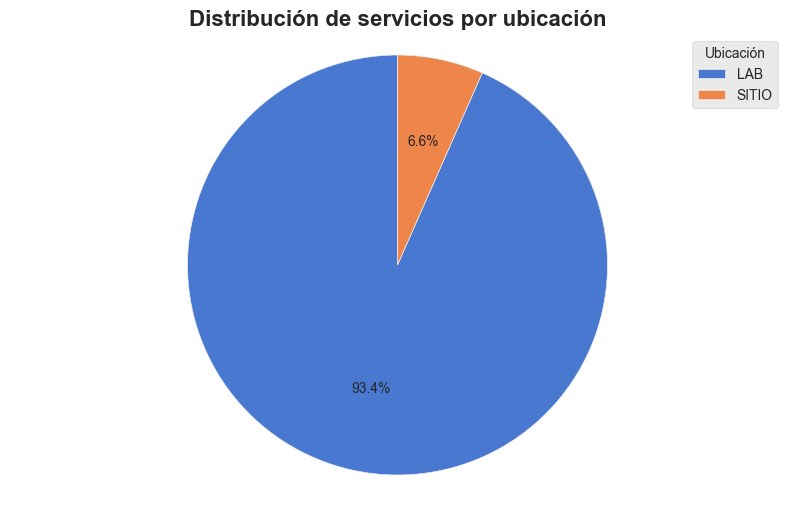

In [ ]:
# Verificamos los valores de la columna 'service_location' para analizar los servicios realizados por ubicación
cal_location = mass_sin_errores.groupby(['service_location'])['report_number'].count().sort_values(ascending=False).reset_index()
#cal_location
# Crear figura
plt.figure(figsize=(10, 6))
#sns.set_palette("muted")

labels = cal_location['service_location'].tolist()
sizes = cal_location['report_number'].tolist()

# Crear gráfico de barras
plt.pie(sizes, autopct='%1.1f%%', startangle=90, colors=sns.color_palette("muted", len(labels)))
plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.title('Distribución de servicios por ubicación', fontsize=16, fontweight='bold')
plt.legend(labels, title='Ubicación', loc='upper right', fontsize=10)
plt.show()

In [ ]:
loc_sitio  = mass_sin_errores[mass_sin_errores['service_location'] == 'SITIO']
loc_sitio = loc_sitio.drop(columns=['service_location'], errors='ignore')
loc_sitio.head(10)

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,priority,piece_count,equipment_type
44,CCM0040.M/2025,H2461,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,II,2024-12-17,2025-01-17,2025-01-14,2025-01-14,2025-01-15,1.0,3.0,ORDINARIO,1.0,Balanza
72,CCM0062.M/2025,H2506,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,II,2025-01-27,2025-02-14,2025-02-11,2025-02-11,2025-02-12,1.0,3.0,ORDINARIO,1.0,Balanza
73,CCM0063.M/2025,H2506,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,I,2025-01-27,2025-02-14,2025-02-11,2025-02-11,2025-02-12,1.0,3.0,ORDINARIO,1.0,Balanza
116,CCM0104.M/2025,I0052,Guillermo Guzmán López,Guillermo Guzmán López,Francisco Torres Cabrera,Francisco Torres Cabrera,II,2025-01-15,NaT,2025-01-29,2025-01-29,2025-02-04,3.0,0.0,ORDINARIO,1.0,Balanza
117,CCM0105.M/2025,I0052,Guillermo Guzmán López,Guillermo Guzmán López,Francisco Torres Cabrera,Francisco Torres Cabrera,I,2025-01-15,NaT,2025-01-29,2025-01-29,2025-02-04,3.0,0.0,ORDINARIO,1.0,Balanza
119,CCM0107.M/2025,I0054,Mario de Jesús García,Mario de Jesús García,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,I,2025-01-15,NaT,2025-01-23,2025-01-23,2025-01-23,0.0,0.0,ORDINARIO,1.0,Balanza
169,CCM0155.M/2025,I0139,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,III,2025-02-17,2025-02-19,2025-02-14,2025-02-14,2025-02-17,1.0,3.0,ORDINARIO,1.0,Balanza
176,CCM0162.M/2025,I0169,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,II,2025-02-04,2025-03-20,2025-03-14,2025-03-14,2025-03-18,1.0,3.0,ORDINARIO,1.0,Balanza
177,CCM0163.M/2025,I0169,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,II,2025-02-04,2025-03-20,2025-03-14,2025-03-14,2025-03-18,1.0,3.0,ORDINARIO,1.0,Balanza
210,CCM0195.M/2025,I0224,Francisco Torres Cabrera,Francisco Torres Cabrera,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,II,2025-02-12,2025-02-28,2025-02-25,2025-02-25,2025-02-25,0.0,3.0,ORDINARIO,1.0,Balanza


In [ ]:
class_per_sitio = loc_sitio.groupby(['classification']).agg(
    rep_qty=('report_number', 'count'),
    deliv_time_avg=('delivery_time', 'mean')
).reset_index()
class_per_sitio = class_per_sitio.sort_values('rep_qty', ascending=False).round(2)
class_per_sitio

,classification,rep_qty,deliv_time_avg
1,II,11,1.73
0,I,8,2.12
2,III,5,1.20


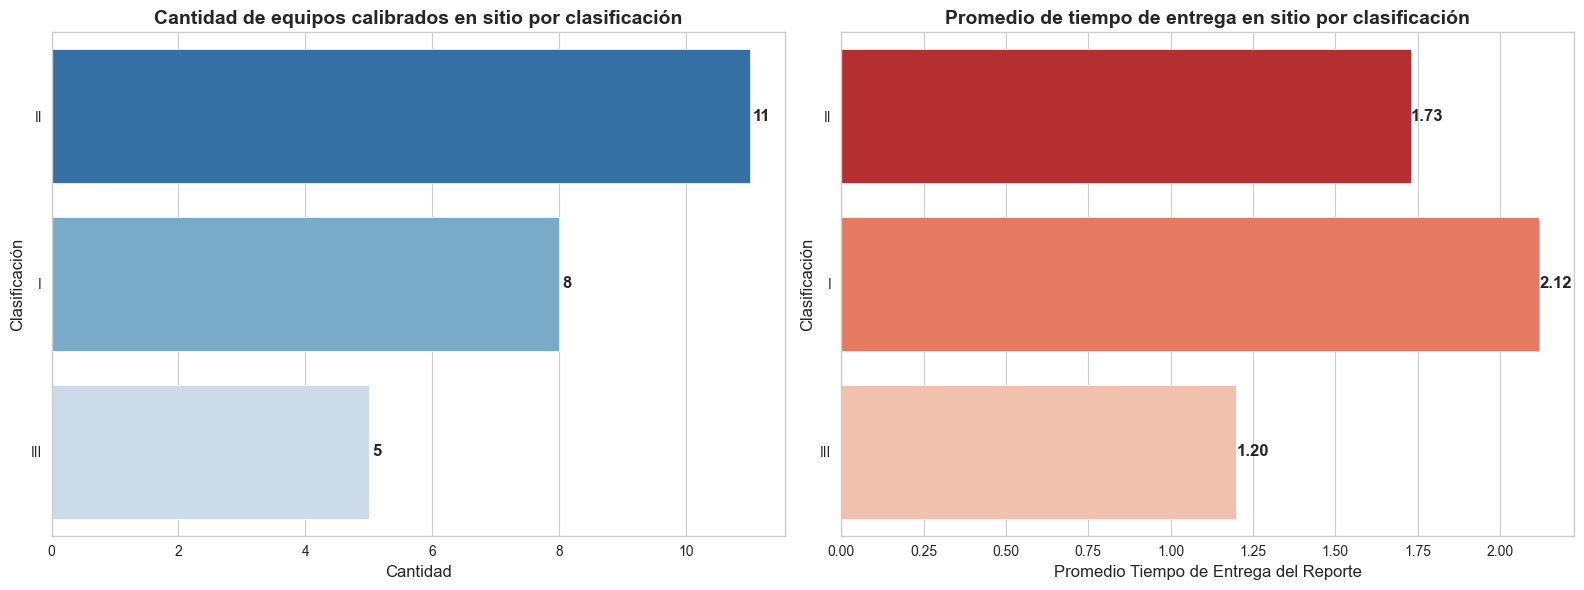

In [ ]:
# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Primer gráfico: Cantidad de equipos por clasificación ---
sns.barplot(data=class_per_sitio, x='rep_qty', y='classification', hue='classification', palette='Blues_r', errorbar=None, legend=False, ax=axes[0])
axes[0].set_xlabel('Cantidad', fontsize=12)
axes[0].set_ylabel('Clasificación', fontsize=12)
axes[0].set_title('Cantidad de equipos calibrados en sitio por clasificación', fontsize=14, fontweight='bold')

# Agregar etiquetas en las barras del primer gráfico
for i, v in enumerate(class_per_sitio['rep_qty']):
    axes[0].text(v + 0.05, i, str(v), va='center', fontsize=12, fontweight='bold')

# --- Segundo gráfico: Promedio de tiempo de entrega por clasificación ---
sns.barplot(data=class_per_sitio, x='deliv_time_avg', y='classification', hue='classification', palette='Reds_r', errorbar=None, legend=False, ax=axes[1])
axes[1].set_xlabel('Promedio Tiempo de Entrega del Reporte', fontsize=12)
axes[1].set_ylabel('Clasificación', fontsize=12)  # Evitar la etiqueta duplicada del eje y
axes[1].set_title('Promedio de tiempo de entrega en sitio por clasificación', fontsize=14, fontweight='bold')
#axes[1].tick_params(axis='y', left=False, labelleft=False) # Ocultar etiquetas del eje y duplicadas

# Agregar etiquetas en las barras del segundo gráfico
for i, v in enumerate(class_per_sitio['deliv_time_avg']):
    axes[1].text(v, i, f'{v:.2f}', va='center', fontsize=12, fontweight='bold')

plt.tight_layout()
plt.show()

## Análisis de Entrega de Certificados por Clasificación – Servicios en Sitio

Dado que la calibración se realiza en un día, las diferencias en tiempos de entrega se deben al proceso de **certificación**. Las principales implicaciones son:

- **Clasificación "I" (2.12 días)**  y **8 servicios**: Tiempo de entrega más alto. Se deben revisar posibles ineficiencias en la generación, revisión o entrega de certificados.
  
- **Clasificación "III" (1.20 días)** y **11 servicios:** Entrega más rápida. Podría servir como modelo para otras clasificaciones.

- **Clasificación "II" (1.73 días)** y **5 servicvios:** Tiempo moderado. Es eficiente.

- **Enfoque en el flujo de certificados:** La calibración no es el problema. Se deben detectar cuellos de botella en la documentación y entrega.

- **Oportunidad de estandarización:** Adaptar las mejores prácticas de la clasificación "III" podría beneficiar a "I" y "II".

- **Revisión de recursos:** Posible necesidad de reforzar personal o herramientas para la clasificación "I" o tener en cuenta el posible impacto en el tiempo de otros servicios asignados al mismo metrólogo.

**Conclusión:** Optimizar el proceso de certificación, especialmente en "I", es clave para reducir tiempos de entrega y minimizar su influencia en los tiempos de otros servicios.


### Se comparan los tiempos de entrega de los certificados por clasificación y por fechas de entrega de los certificados para ver si existe alguna relación con los tiempos de entrega de los mismos

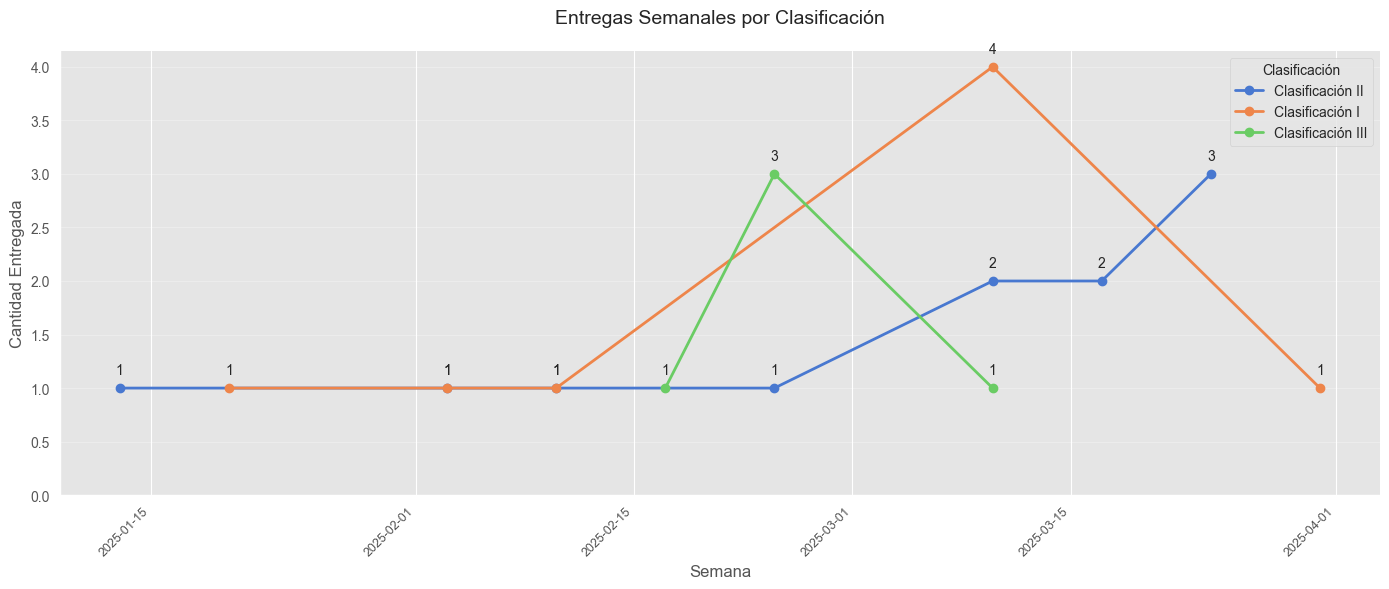

In [ ]:
# Copiar y limpiar el dataframe
df = loc_sitio.copy()
df.rename(columns={'delivery_date ': 'delivery_date'}, inplace=True)  # eliminar espacio
#df['delivery_date'] = pd.to_datetime(df['delivery_date '.strip()])  # eliminar espacio
df['week_start'] = df['delivery_date'].dt.to_period('W').dt.start_time

# Agrupar entregas por semana y clasificación
weekly_counts = df.groupby(['week_start', 'classification']).size().reset_index(name='cantidad')

# Gráfico
plt.figure(figsize=(14, 6))

for clas in weekly_counts['classification'].unique():
    subset = weekly_counts[weekly_counts['classification'] == clas]
    
    # Línea por clasificación
    plt.plot(subset['week_start'], 
             subset['cantidad'], 
             marker='o', 
             linewidth=2, 
             label=f'Clasificación {clas}')
    
    # Etiquetas por punto
    for i, row in subset.iterrows():
        plt.text(row['week_start'], row['cantidad'] + 0.1, str(row['cantidad']),
                 ha='center', va='bottom', fontsize=10)

# Estética
plt.title('Entregas Semanales por Clasificación', fontsize=14, pad=20)
plt.xlabel('Semana')
plt.ylabel('Cantidad Entregada')
plt.xticks(rotation=45, ha='right', fontsize=9)
plt.grid(axis='y', alpha=0.3)
plt.ylim(bottom=0)
plt.legend(title='Clasificación')
sns.despine()
plt.tight_layout()
plt.show()

## Análisis de Entrega de Certificados por Clasificación – Servicios en Sitio a lo largo del tiempo

Los principales hallazgos son:

- **Primera quincena de marzo:** Hubo la mayor cantidad de servicios (7), por lo que seguramente tuvo influencia en los tiempos de entrega. 
  
- **Clasificación "I" (4 servicios en una misma quincena):** Unido a otros 2 servicios en balanzas del **tipo I* y 1 balanza del tipo III, por lo que tuvo gran influencia en el tiempo de entrega en las balanzas del tipo I.  

- **Semanas críticas:** La primera quincena de marzo requiere asignación prioritaria de recursos para evitar retrasos recurrentes, tanto en servicios en sitio como en el laboratorio.

## Analicemos ahora los servicios de calibración en el laboratorio

In [ ]:
loc_lab  = mass_sin_errores[mass_sin_errores['service_location'] == 'LAB']
loc_lab = loc_lab.drop(columns=['service_location'], errors='ignore')
loc_lab.head(10)

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,priority,piece_count,equipment_type
0,CCM0001.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
1,CCM0002.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
2,CCM0003.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
3,CCM0004.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
4,CCM0005.M/2025 v0,I0082,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2025-01-21,2025-01-31,2025-01-21,2025-01-30,2025-01-30,7.0,8.0,ORDINARIO,1.0,Pesa
5,CCM0005.M/2025 v1,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
6,CCM0006.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
7,CCM0007.M/2025,H2395,Francisco Torres Cabrera,Francisco Torres Cabrera,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,E2,2024-12-06,2025-01-08,2024-12-06,2025-01-07,2025-01-07,20.0,21.0,ORDINARIO,22.0,Pesa
8,CCM0008.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,2025-01-06,2025-01-06,18.0,18.0,ORDINARIO,4.0,Pesa
9,CCM0009.M/2025,H2403,Guillermo Guzmán López,Guillermo Guzmán López,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-09,2025-01-06,2025-01-02,2025-01-06,2025-01-06,18.0,18.0,ORDINARIO,3.0,Pesa


In [ ]:
loc_lab.info()

<class 'pandas.core.frame.DataFrame'>
Index: 339 entries, 0 to 385
Data columns (total 17 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   report_number            339 non-null    object        
 1   so                       339 non-null    object        
 2   assignee                 339 non-null    object        
 3   calibrator               339 non-null    object        
 4   supervisor               339 non-null    object        
 5   approver                 339 non-null    object        
 6   classification           339 non-null    object        
 7   lab_received_date        339 non-null    datetime64[ns]
 8   scheduled_delivery_date  339 non-null    datetime64[ns]
 9   cleaning_date            335 non-null    datetime64[ns]
 10  calibration_date         339 non-null    datetime64[ns]
 11  delivery_date            339 non-null    datetime64[ns]
 12  delivery_time            339 non-null    

In [ ]:
# Verificamos los valores nulos de las columnas con valores faltantes en la tabla

resultado = pysqldf("""
    SELECT report_number, cleaning_date
    FROM loc_lab
    WHERE scheduled_delivery_date IS NULL or cleaning_date IS NULL """)

resultado

,report_number,cleaning_date
0,CCM0091.M/2025,None
1,CCM0184.M/2025,None
2,CCM0268.M/2025,None
3,CCM0269.M/2025,None


**Los valores faltantes son consistentes con los datos y por tanto se mantienen de esa forma.**

##### Buscamos si quedaron algunos valores duplicados

In [ ]:
no_dup = loc_lab[loc_lab.duplicated(keep=False)]
no_dup

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,priority,piece_count,equipment_type


#### No hay elementos duplicados en la tabla, por lo que no es necesario eliminar duplicados

### Análisis de la cantidad de reportes y piezas por clasificación de equipo

In [ ]:
qty_per_class = loc_lab.groupby(['classification']).agg(
    rep_qty=('report_number', 'count'),
    qty_pieces=('piece_count', 'sum'),
    deliv_time_avg=('delivery_time', 'mean')
).reset_index()
qty_per_class = qty_per_class.sort_values('rep_qty', ascending=False).round(2)
qty_per_class

,classification,rep_qty,qty_pieces,deliv_time_avg
4,E2,142,771.0,11.63
5,F1,108,641.0,8.80
7,M1,53,332.0,8.49
6,F2,21,143.0,9.05
0,1,4,32.0,12.50
1,2,4,4.0,14.00
3,E1,3,51.0,37.33
8,M2,3,8.0,9.67
2,6,1,2.0,5.00


In [ ]:
totales = qty_per_class[['rep_qty', 'qty_pieces']].sum()
totales

rep_qty        339.0
qty_pieces    1984.0
dtype: float64

<Figure size 1000x700 with 0 Axes>

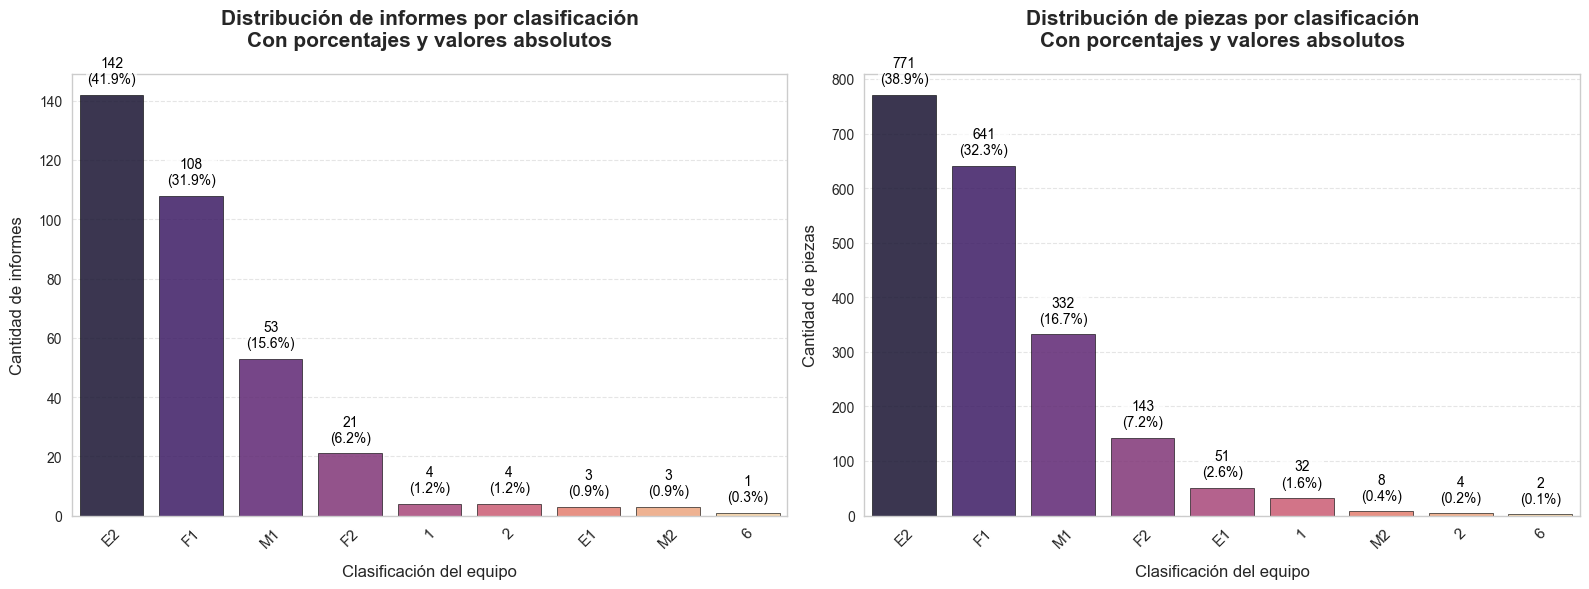

In [ ]:
plt.figure(figsize=(10, 7))
sns.set_style("whitegrid")

# Crear una figura con dos subplots (1 fila, 2 columnas)
fig, axes = plt.subplots(1, 2, figsize=(16, 6))

# --- Primer gráfico: Cantidad de informes por clasificación ---
# Calculamos los porcentajes
total = qty_per_class['rep_qty'].sum()
qty_per_class['percentage'] = (qty_per_class['rep_qty'] / total) * 100

sns.barplot(
    x='classification',
    y='rep_qty',
    hue='classification',  # Added to address warning
    data=qty_per_class,
    palette='magma',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
    dodge=False,  # Prevents side-by-side bars when using hue
    legend=False,
    ax=axes[0]  # Hides redundant legend
)

# Añadir etiquetas con valores absolutos y porcentajes
for i, bar in enumerate(axes[0].patches):
    height = bar.get_height()
    percentage = qty_per_class['percentage'].iloc[i]
    
    axes[0].text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height + (0.02 * max(qty_per_class['rep_qty'])),  # Offset dinámico
        s=f"{height:.0f}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Mejorar el título y etiquetas
axes[0].set_title("Distribución de informes por clasificación\nCon porcentajes y valores absolutos", 
                  fontsize=15, pad=20, fontweight='bold')
axes[0].set_xlabel("Clasificación del equipo", fontsize=12, labelpad=10)
axes[0].set_ylabel("Cantidad de informes", fontsize=12, labelpad=10)

# Rotación y formato de ejes
axes[0].tick_params(axis='x', rotation=45, labelsize=11)
axes[0].tick_params(axis='y', labelsize=10)

# Cuadrícula
axes[0].grid(axis='y', linestyle='--', alpha=0.5)

# --- Segundo gráfico: Cantidad de piezas por clasificación ---
# Calculamos los porcentajes
total = qty_per_class['qty_pieces'].sum()
qty_per_class['percentage'] = (qty_per_class['qty_pieces'] / total) * 100

# Ordenar el DataFrame por 'qty_pieces' de forma descendente
qty_per_class_ordenado = qty_per_class.sort_values(by='qty_pieces', ascending=False)

sns.barplot(
    x='classification',
    y='qty_pieces',
    hue='classification',  # Added to address warning
    data=qty_per_class_ordenado,  # Usar el DataFrame ordenado
    palette='magma',
    edgecolor='black',
    linewidth=0.5,
    alpha=0.85,
    dodge=False,  # Prevents side-by-side bars when using hue
    legend=False,
    ax=axes[1]  # Hides redundant legend
)

# Añadir etiquetas con valores absolutos y porcentajes
for i, bar in enumerate(axes[1].patches):
    height = bar.get_height()
    percentage = qty_per_class_ordenado['percentage'].iloc[i]  # Usar el DataFrame ordenado

    axes[1].text(
        x=bar.get_x() + bar.get_width() / 2,
        y=height + (0.02 * max(qty_per_class_ordenado['qty_pieces'])),  # Offset dinámico
        s=f"{height:.0f}\n({percentage:.1f}%)",
        ha="center",
        va="bottom",
        fontsize=10,
        color='black',
        bbox=dict(facecolor='white', alpha=0.7, edgecolor='none', pad=1)
    )

# Mejorar el título y etiquetas
axes[1].set_title("Distribución de piezas por clasificación\nCon porcentajes y valores absolutos",
                    fontsize=15, pad=20, fontweight='bold')
axes[1].set_xlabel("Clasificación del equipo", fontsize=12, labelpad=10)
axes[1].set_ylabel("Cantidad de piezas", fontsize=12, labelpad=10)

# Rotación y formato de ejes
axes[1].tick_params(axis='x', rotation=45, labelsize=11)
axes[1].tick_params(axis='y', labelsize=10)

# Cuadrícula
axes[1].grid(axis='y', linestyle='--', alpha=0.5)

# Ajustar márgenes
plt.tight_layout()
plt.show()


### Distribución de Informes y Cantidad de Piezas por Clasificación  


### 🔍 Hallazgos Clave  
1. **Dominancia clara**:  
   - La clasificación **E2** concentra el **41.9% del total de informes** (339 informes) y el **38.9% de las piezas** (1984 piezas).  
   - Las categorías (E2, F1, M1 Y F2) representan **95.6%** del total de informes (339 informes) y el **95.1%** de las piezas (1984 piezas). 

2. **Cola larga**:  
   - 5 clasificaciones (1, 2, E1, M2 y 6) con ≤ 5.0% de participación en total de informes y de piezas.
   - La clasificación **E1** tiene un número significativo de piezas (2.6% del total), pero solo representa el **0.9% de los informes**, lo que sugiere que cada informe involucra un número elevado de piezas.

## Análisis de los tiempos de entrega por clasificación de equipo

In [ ]:
class_del_time = qty_per_class[['classification','rep_qty', 'qty_pieces', 'deliv_time_avg']].sort_values(by='deliv_time_avg', ascending=False).reset_index(drop=True)
class_del_time['pieces_per_report'] = class_del_time['qty_pieces'] / class_del_time['rep_qty']
class_del_time['pieces_per_report'] = class_del_time['pieces_per_report'].round(2)
class_del_time

,classification,rep_qty,qty_pieces,deliv_time_avg,pieces_per_report
0,E1,3,51.0,37.33,17.00
1,2,4,4.0,14.00,1.00
2,1,4,32.0,12.50,8.00
3,E2,142,771.0,11.63,5.43
4,M2,3,8.0,9.67,2.67
5,F2,21,143.0,9.05,6.81
6,F1,108,641.0,8.80,5.94
7,M1,53,332.0,8.49,6.26
8,6,1,2.0,5.00,2.00


class_del_time = mass_sin_errores.groupby(['classification'])['delivery_time'].mean().round(2).reset_index()
class_del_time

C:\Users\Miguel Oscar\AppData\Local\Temp\ipykernel_23940\3614716414.py:3: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


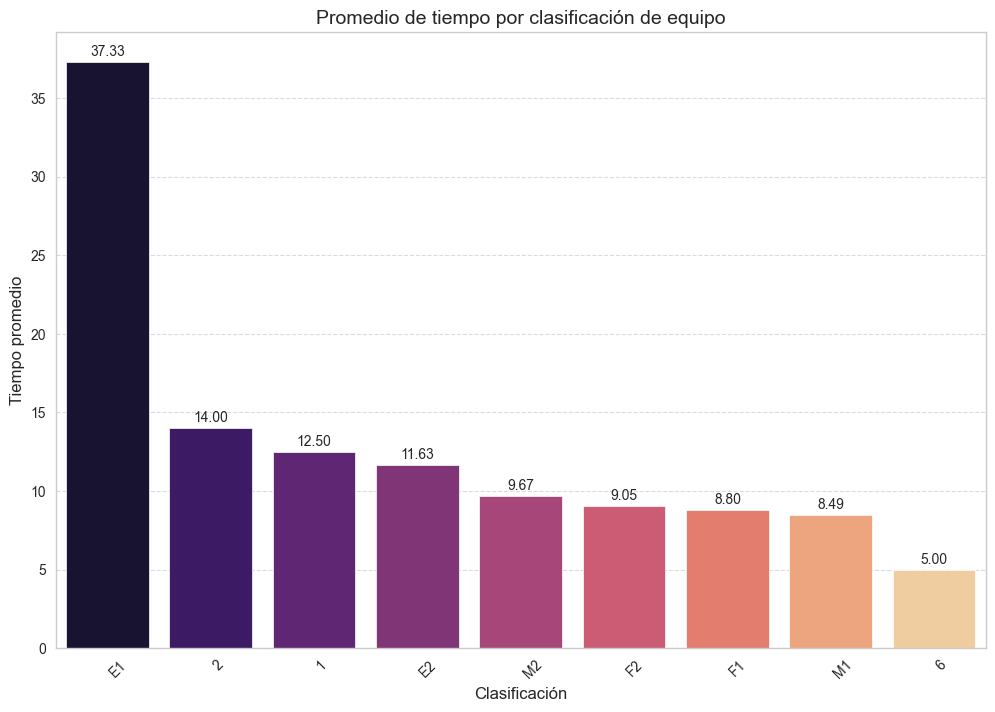

In [ ]:

plt.figure(figsize=(12, 8))
# Sintaxis básica
ax = sns.barplot(
    x='classification',  # Variable categórica (eje x)
    y='deliv_time_avg',   # Variable numérica (eje y)
    data=class_del_time,
    #estimator='mean',  # Función de agregación (mean, sum, median, etc.)
    palette='magma',            # Intervalo de confianza (o 'sd' para desviación estándar)
    #color='blue'       # Color de las barras
)

# Añadir los valores en las barras
for bar in ax.patches:
    height = bar.get_height()
    ax.text(
        x=bar.get_x() + bar.get_width() / 2,  # Posición horizontal centrada
        y=height + 0.2,                       # Posición vertical (altura + offset)
        s=f"{height:.2f}",                    # Texto (2 decimales)
        ha="center",                           # Alineación horizontal
        va="bottom",                           # Alineación vertical
        fontsize=10
    )

plt.title("Promedio de tiempo por clasificación de equipo", fontsize=14)
plt.xlabel("Clasificación", fontsize=12)
plt.ylabel("Tiempo promedio", fontsize=12)
plt.xticks(rotation=45, ha='left', fontsize=10)
plt.grid(axis='y', linestyle='--', alpha=0.7)  # Solo líneas de cuadrícula en el eje y

plt.show()

# Análisis de Casos Atípicos y Recomendaciones

## 🔴 Casos Atípicos Identificados

### 1. Demora Extrema en Calibración (37.33 días)
- **Descripción**:  
  Tiempo de calibración 7.5 veces mayor que el valor más bajo (5 días)
- **Impacto**:  
  Puede retrasar toda la cadena de procesos del laboratorio

## 🛠 Recomendaciones Específicas

### Para Demora de 37.33 Días
1. **Acción Inmediata**:  
    - Revisar el caso específico para entender la causa de la demora.
    - Considerar la posibilidad de un mapeo del proceso que permita identificar los cuellos de botella.
    - Analizar si el tiempo de entrega se vio afectado por la cantidad de piezas enviadas o por la complejidad del equipo.
2. **Revisión del proceso**:
    - Evaluar si el tiempo de entrega asignado es adecuado para este tipo de calibración.
    - Considerar la posibilidad de ajustar los tiempos asignados para evitar demoras excesivas en el futuro.
3. **Documentación**:
    - Registrar el caso y las acciones tomadas para futuras referencias.
    - Utilizar esta información para mejorar los procesos y evitar demoras similares en el futuro.
4. **Análisis de datos**:
    - Realizar un análisis de datos para identificar patrones o tendencias en los tiempos de entrega.
    - Utilizar esta información para mejorar la planificación y la gestión de recursos en el laboratorio.

### --------------------------------------------------------------------------------------------------

## Análisis de los tiempos de entrega vs los tiempos asignados

In [ ]:
tiempo = loc_lab.groupby(['classification']).agg(
    rep_qty=('report_number', 'count'),
    qty_pieces=('piece_count', 'sum'),
    deliv_time_avg=('delivery_time', 'mean'),
    assigned_time_avg=('assigned_time', 'mean'),
    pieces_per_report=('piece_count', lambda x: x.sum() / len(x)),
).reset_index()
tiempo = tiempo.sort_values('rep_qty', ascending=False).round(2)
tiempo

,classification,rep_qty,qty_pieces,deliv_time_avg,assigned_time_avg,pieces_per_report
4,E2,142,771.0,11.63,15.58,5.43
5,F1,108,641.0,8.80,12.60,5.94
7,M1,53,332.0,8.49,12.30,6.26
6,F2,21,143.0,9.05,12.90,6.81
0,1,4,32.0,12.50,15.50,8.00
1,2,4,4.0,14.00,18.00,1.00
3,E1,3,51.0,37.33,30.00,17.00
8,M2,3,8.0,9.67,14.00,2.67
2,6,1,2.0,5.00,12.00,2.00


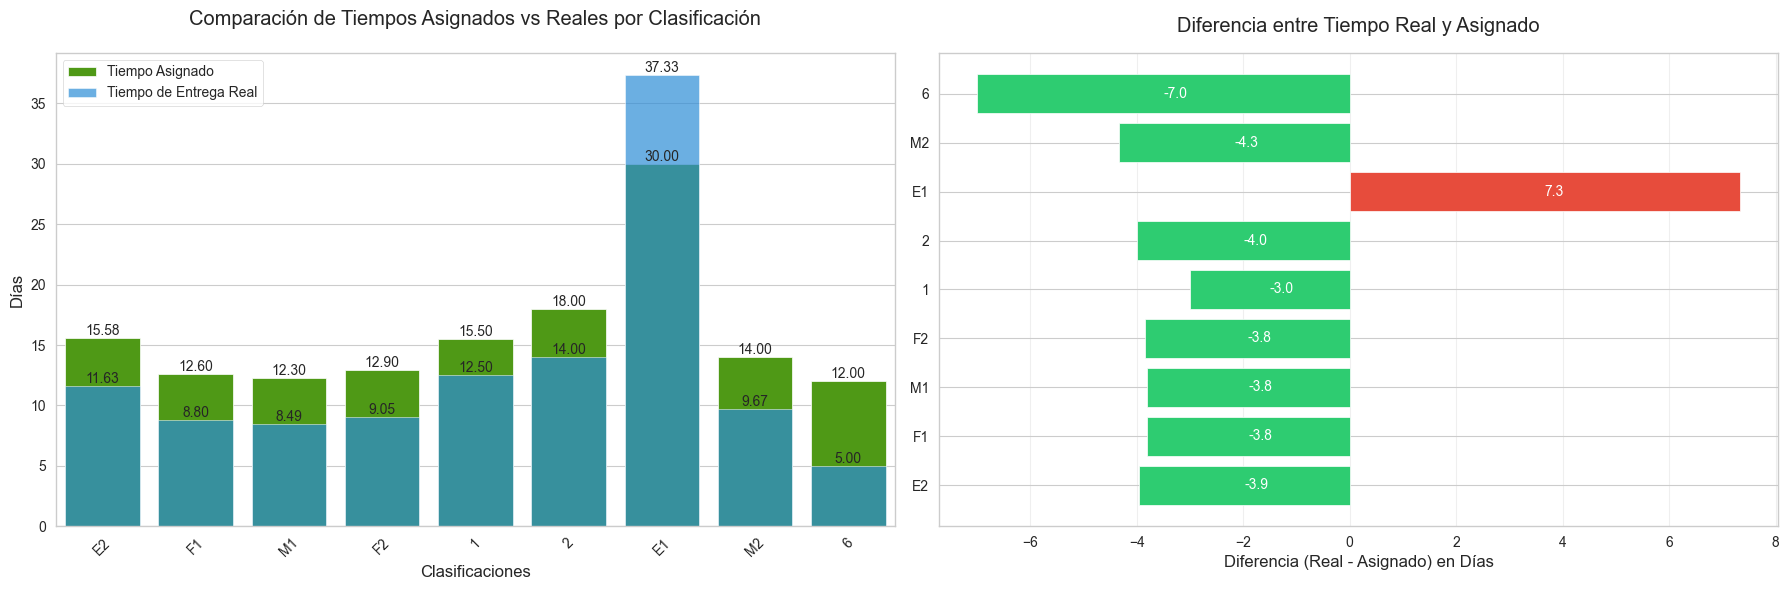

In [ ]:
equipos = tiempo['classification'].tolist()
asignado = tiempo['assigned_time_avg'].tolist()
real = tiempo['deliv_time_avg'].tolist()
diferencias = [r - a for r, a in zip(real, asignado)]

# Configurar la figura con dos subplots
fig, axes = plt.subplots(1, 2, figsize=(18, 6))

# --- Primer Gráfico: Comparación de Tiempos Asignados vs Reales ---
ax1 = axes[0]
sns.barplot(x=equipos, y=asignado, color='#4CAF00', label='Tiempo Asignado', ax=ax1)
sns.barplot(x=equipos, y=real, color='#1191F3', label='Tiempo de Entrega Real', alpha=0.7, ax=ax1)

# Personalización del primer gráfico
ax1.set_title('Comparación de Tiempos Asignados vs Reales por Clasificación', pad=20)
ax1.set_xlabel('Clasificaciones')
ax1.set_ylabel('Días')
ax1.tick_params(axis='x', rotation=45)
ax1.legend()

# Añadir valores al primer gráfico
for p in ax1.patches:
    ax1.annotate(f'{p.get_height():.2f}',
                 (p.get_x() + p.get_width() / 2., p.get_height()),
                 ha='center', va='center',
                 xytext=(0, 5),
                 textcoords='offset points')

# --- Segundo Gráfico: Diferencia entre Tiempo Real y Asignado ---
ax2 = axes[1]
bars = ax2.barh(equipos, diferencias, color=np.where(np.array(diferencias) > 0, '#e74c3c', '#2ecc71'))

# Personalización del segundo gráfico
ax2.set_title('Diferencia entre Tiempo Real y Asignado', pad=15)
ax2.set_xlabel('Diferencia (Real - Asignado) en Días')
ax2.grid(axis='x', alpha=0.3)

# Añadir valores al segundo gráfico
for bar in bars:
    width = bar.get_width()
    ax2.text(width/2, bar.get_y() + bar.get_height()/2,
             f'{width:.1f}',
             va='center',
             color='white' if abs(width) > 1 else 'black')

plt.tight_layout()
plt.show()

## Análisis General

**1.📊 Sobrestimación General:**  
En la mayoría de las clasificaciones, el tiempo asignado parece ser una sobreestimación del tiempo de entrega real. Esto podría indicar:
- Procesos operativos eficientes.
- Planificación conservadora en la asignación.
- Ajustar los tiempos asignados para reflejar mejor la realidad operativa.
- Oportunidad de optimización en la asignación de tiempos.

**2.⚠️ Problema Crítico en la Clasificación "2":**  
La clasificación "2" presenta una desviación alarmante:
- Tiempo real **excede significativamente** el asignado.
- Requiere investigación inmediata para identificar:
  - Cuellos de botella operativos.
  - Errores en la estimación inicial.

**3.📊 Variabilidad en la Precisión de la Estimación:**  
- Magnitud de diferencias (real vs. asignado) varía entre clasificaciones.
- Sugiere inconsistencias en los métodos de estimación.

**4.🔍 Potencial de Optimización:**  
- Tiempo real menor al asignado en la mayoría de casos señala oportunidades para:
  - Ajustar estándares de planificación.
  - Reducir márgenes de seguridad excesivos.
  - Verificar el impacto de la cantidad de piezas en el tiempo de entrega.
  - Considerar la posibilidad de ajustar los tiempos asignados para evitar sobrecargas en el proceso de calibración.

---

##💡 Puntos Clave para la Acción

1. **Prioridad Urgente: Clasificación "2"**  
   - Realizar análisis de causa raíz (ej: diagrama de Ishikawa o de espina de pescado).
   - Evaluar recursos asignados vs. requerimientos reales.

2. **Analizar Diferencias Negativas Destacadas**  
   - Identificar prácticas eficientes en clasificaciones con:
   - Diferencias negativas mayores a 2 días.
   - Replicar buenas prácticas en otras áreas.

3. **Revisión del Proceso de Estimación**  
   - Revisar las metodologías actuales de asignación de tiempos.
   - Implementar sistema de feedback continuo entre equipos operativos y de planificación.

---

**Conclusión**  
El gráfico revela:  
⚠️ **Falla crítica en Clasificación "2"** (tiempo de entrega excesivo)  
✅ **Sobrestimación sistemática** en otras clasificaciones (oportunidad de optimización).  

*Acciones recomendadas:*  
- Corrección inmediata para Clasificación "2".  
- Estandarización de procesos de estimación con datos históricos.  

# -------------------------------------------------------------------

In [ ]:
loc_lab

,report_number,so,assignee,calibrator,supervisor,approver,classification,lab_received_date,scheduled_delivery_date,cleaning_date,calibration_date,delivery_date,delivery_time,assigned_time,priority,piece_count,equipment_type
0,CCM0001.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
1,CCM0002.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
2,CCM0003.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
3,CCM0004.M/2025,H2381,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2024-12-05,2025-01-06,2024-12-06,2025-01-10,2025-01-10,24.0,20.0,ORDINARIO,1.0,Pesa
4,CCM0005.M/2025 v0,I0082,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,Gabriel Gallardo Camacho,Gabriel Gallardo Camacho,E2,2025-01-21,2025-01-31,2025-01-21,2025-01-30,2025-01-30,7.0,8.0,ORDINARIO,1.0,Pesa
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
381,CCM1842.M/2024,H2416,Mario de Jesús García,Mario de Jesús García,Leobardo Maximiliano Brito Fonseca,Leobardo Maximiliano Brito Fonseca,M1,2024-12-10,2025-01-07,2024-12-17,2024-12-19,2025-01-07,18.0,18.0,ORDINARIO,2.0,Pesa
382,CCM1862.M/2024,H2428,Sergio Cruz Santiago,Sergio Cruz Santiago,Francisco Torres Cabrera,Francisco Torres Cabrera,2,2024-12-11,2025-01-08,2024-12-12,2024-12-20,2025-01-02,14.0,18.0,ORDINARIO,1.0,Pesa
383,CCM1863.M/2024,H2428,Sergio Cruz Santiago,Sergio Cruz Santiago,Francisco Torres Cabrera,Francisco Torres Cabrera,2,2024-12-11,2025-01-08,2024-12-12,2024-12-20,2025-01-02,14.0,18.0,ORDINARIO,1.0,Pesa
384,CCM1864.M/2024,H2428,Sergio Cruz Santiago,Sergio Cruz Santiago,Francisco Torres Cabrera,Francisco Torres Cabrera,2,2024-12-11,2025-01-08,2024-12-12,2024-12-20,2025-01-02,14.0,18.0,ORDINARIO,1.0,Pesa


In [ ]:
loc_lab.columns

Index(['report_number', 'so', 'assignee', 'calibrator', 'supervisor',
       'approver', 'classification', 'lab_received_date',
       'scheduled_delivery_date', 'cleaning_date', 'calibration_date',
       'delivery_date ', 'delivery_time', 'assigned_time', 'priority',
       'piece_count', 'equipment_type'],
      dtype='object')

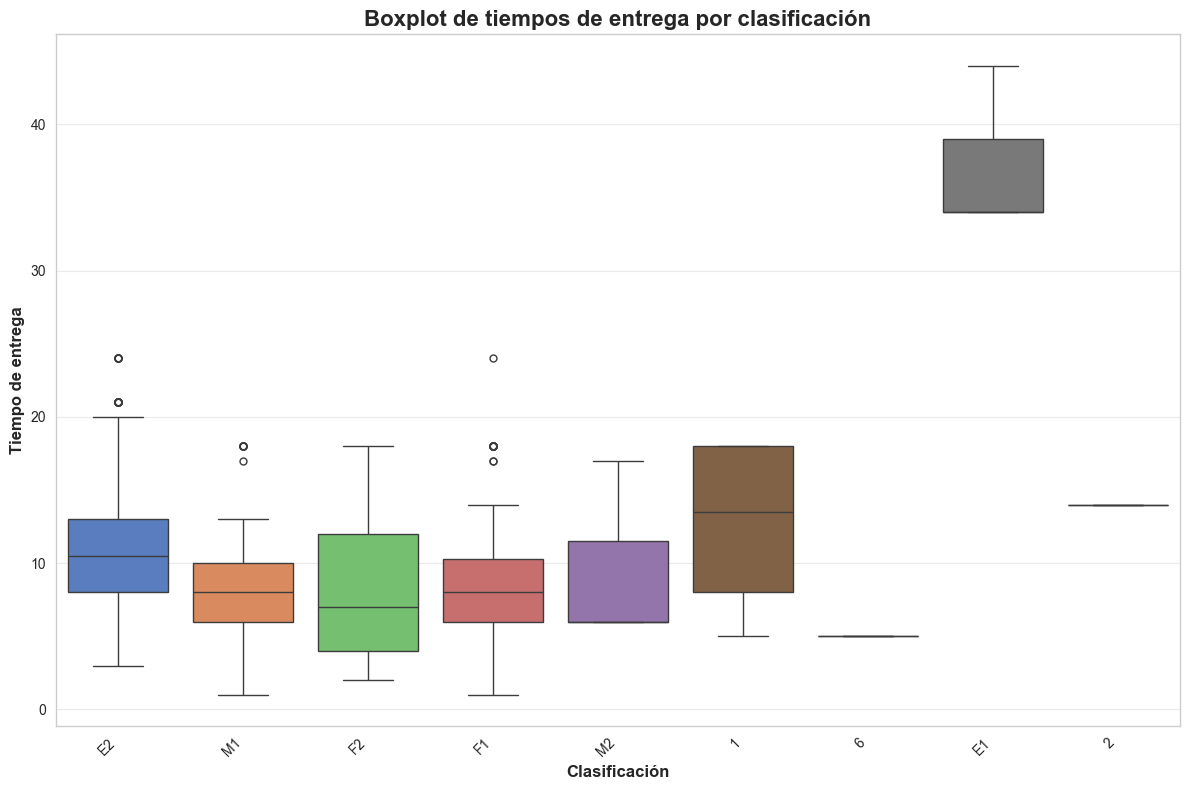

In [ ]:
fig, ax = plt.subplots(figsize=(12, 8))
boxplot = sns.boxplot(x='classification', y='delivery_time', hue='classification', 
                      data=loc_lab, width=0.8, fliersize=5, whis=1.5, ax=ax)

# Añadir etiquetas a los outliers
for i, artist in enumerate(boxplot.artists):
    # Obtener la clasificación actual
    classification = loc_lab['classification'].unique()[i]
    
    # Obtener los datos para esta clasificación
    category_data = loc_lab[loc_lab['classification'] == classification]['delivery_time']
    
    # Calcular Q1, Q3 e IQR
    Q1 = np.percentile(category_data, 25)
    Q3 = np.percentile(category_data, 75)
    IQR = Q3 - Q1
    
    # Identificar outliers
    outliers = category_data[(category_data < Q1 - 1.5 * IQR) | (category_data > Q3 + 1.5 * IQR)]
    
    # Para cada outlier, añadir una etiqueta
    for outlier_value in outliers:
        # Obtener el índice/fila del outlier
        outlier_index = loc_lab[(loc_lab['classification'] == classification) & 
                               (loc_lab['delivery_time'] == outlier_value)].index
        
        # Para cada índice encontrado (podría haber múltiples filas con el mismo valor)
        for idx in outlier_index:
            # Obtener la posición x (basada en la posición de la categoría)
            x_pos = i
            
            # Añadir etiqueta de texto
            ax.text(x_pos, outlier_value, f'{idx}', 
                    ha='center', va='bottom', fontsize=9, 
                    color='red', fontweight='bold')

# Personalizar el gráfico
plt.title('Boxplot de tiempos de entrega por clasificación', fontsize=16, fontweight='bold')
plt.xlabel('Clasificación', fontsize=12, fontweight='bold')
plt.ylabel('Tiempo de entrega', fontsize=12, fontweight='bold')
plt.xticks(rotation=45, ha='right', fontsize=10)
plt.grid(axis='y', alpha=0.4)
plt.tight_layout()  # Ajustar diseño para evitar recortes
plt.show()

# Análisis: Boxplot de Tiempos de Entrega por Clasificación

## Hallazgos principales

- **E1**: Tiempos de entrega significativamente superiores (33-39 días), con distribución compacta que indica consistencia.

- **Clasificaciones estándar** (E2, F1, F2, M1, M2, 1): Presentan medianas entre 7-13 días, formando un grupo homogéneo con variaciones moderadas.

- **Outliers**: Detectados principalmente en E2, F1 y M1, con tiempos de entrega atípicos que llegan hasta ~24 días.

- **Casos especiales**: 
  - Clasificación "6": Valor único o muy poca variación (~5 días)
  - Clasificación "2": Distribución extremadamente compacta (~13 días)

## Variabilidad por clasificación

| Clasificación | Variabilidad | Mediana aproximada | Outliers |
|---------------|--------------|-------------------|----------|
| E1 | Baja | 35 días | No |
| 1 | Alta | 13 días | No |
| E2 | Media | 10 días | Sí (2) |
| F1 | Media | 8 días | Sí (3) |
| F2 | Alta | 7 días | No |
| M1 | Media | 8 días | Sí (2) |
| M2 | Media | 9 días | No |
| 6 | Muy baja | 5 días | No |
| 2 | Muy baja | 13 días | No |

## Implicaciones

1. **Segmentación clara**: E1 constituye un grupo completamente separado, que requeriría expectativas de entrega diferentes.

2. **Predictibilidad**: Las clasificaciones con baja variabilidad (E1, 6, 2) permiten estimaciones más precisas de tiempos de entrega.

3. **Investigación necesaria**: Los outliers identificados en varias clasificaciones sugieren incidentes específicos que merecen análisis para determinar causas de retrasos.

# ---------------------------------------------------------------------------

## Se comparan los tiempos de entrega promedios por clasificación de equipo para ver si existe alguna relación con la cantidad de piezas promedio por por cada clase.


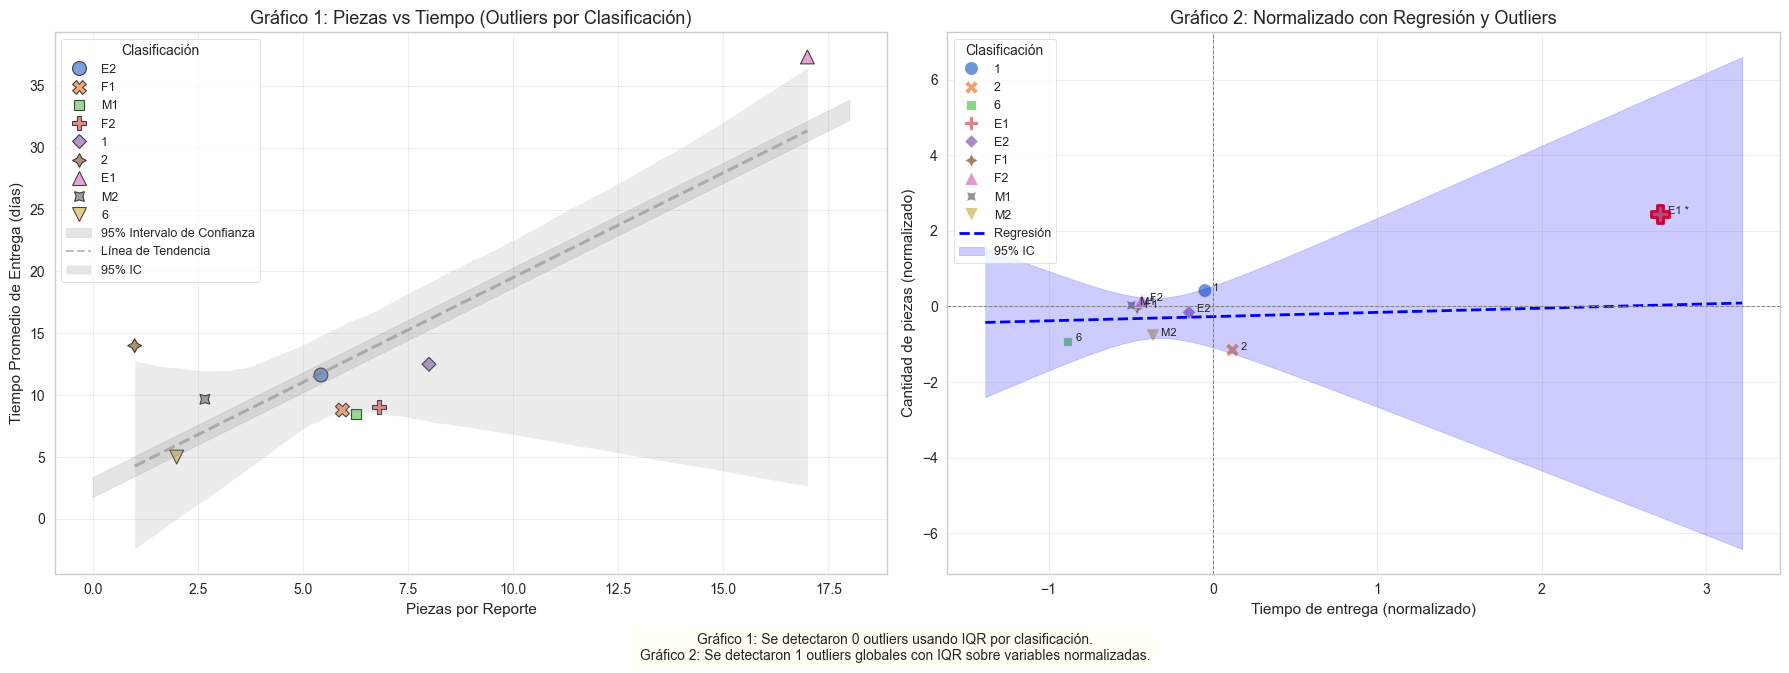

In [ ]:
from scipy import stats
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression

# Preparar los datos (asumiendo que 'tiempo' es el DataFrame original)
df1 = tiempo.reset_index()
df2 = tiempo[['classification', 'deliv_time_avg', 'pieces_per_report']].copy()
df2.rename(columns={'classification': 'Clasificación',
                    'deliv_time_avg': 'Tiempo_entrega',
                    'pieces_per_report': 'Cantidad_piezas'}, inplace=True)
df2['Clasificación'] = df2['Clasificación'].astype('category')

# === FIGURA Y ESTILO GENERAL ===
sns.set_style("whitegrid")
sns.set_palette("muted")
fig, axs = plt.subplots(1, 2, figsize=(18, 7))
plt.subplots_adjust(wspace=0.3)

# === GRÁFICO 1: Sin normalizar, detección IQR por grupo ===
def detect_outliers(df, variables):
    outlier_indices = []
    for var in variables:
        for classification, group in df.groupby('classification'):
            Q1 = group[var].quantile(0.25)
            Q3 = group[var].quantile(0.75)
            IQR = Q3 - Q1
            lower = Q1 - 1.5 * IQR
            upper = Q3 + 1.5 * IQR
            outliers = group[(group[var] < lower) | (group[var] > upper)]
            outlier_indices.extend(outliers.index.difference(outlier_indices))
    return outlier_indices

outlier_indices = detect_outliers(df1, ['pieces_per_report', 'deliv_time_avg'])
df1['is_outlier'] = df1.index.isin(outlier_indices)

# Scatterplot sin outliers
sns.scatterplot(
    data=df1[~df1['is_outlier']],
    x='pieces_per_report',
    y='deliv_time_avg',
    hue='classification',
    style='classification',
    s=100, alpha=0.7, edgecolor='black',
    ax=axs[0]
)

# Outliers resaltados
sns.scatterplot(
    data=df1[df1['is_outlier']],
    x='pieces_per_report',
    y='deliv_time_avg',
    hue='classification',
    style='classification',
    s=150, alpha=1.0, edgecolor='red', linewidth=2,
    legend=False, ax=axs[0]
)

# Línea de regresión (sin outliers)
sns.regplot(
    data=df1[~df1['is_outlier']],
    x='pieces_per_report',
    y='deliv_time_avg',
    scatter=False,
    color='gray', line_kws={'linestyle':'--', 'alpha':0.5},
    ax=axs[0]
)

# Intervalo de confianza
x = df1.loc[~df1['is_outlier'], 'pieces_per_report'].values
y = df1.loc[~df1['is_outlier'], 'deliv_time_avg'].values
slope, intercept, _, _, std_err = stats.linregress(x, y)
x_pred = np.linspace(df1['pieces_per_report'].min() - 1, df1['pieces_per_report'].max() + 1, 100)
y_pred = intercept + slope * x_pred
axs[0].fill_between(
    x_pred,
    y_pred - 1.96 * std_err,
    y_pred + 1.96 * std_err,
    alpha=0.2, color='gray', label='95% Intervalo de Confianza'
)

# Anotaciones de outliers
for idx in outlier_indices:
    row = df1.loc[idx]
    axs[0].annotate(
        f"{row['classification']} (Outlier)",
        xy=(row['pieces_per_report'], row['deliv_time_avg']),
        xytext=(10, 10),
        textcoords='offset points',
        arrowprops=dict(arrowstyle='->', color='red', lw=1.5),
        fontsize=8, color='darkred', weight='bold'
    )

axs[0].set_title("Gráfico 1: Piezas vs Tiempo (Outliers por Clasificación)", fontsize=13)
axs[0].set_xlabel("Piezas por Reporte", fontsize=11)
axs[0].set_ylabel("Tiempo Promedio de Entrega (días)", fontsize=11)
axs[0].grid(True, alpha=0.3)

# Leyenda personalizada
handles, labels = axs[0].get_legend_handles_labels()
handles.append(plt.Line2D([0], [0], color='gray', linestyle='--', alpha=0.5))
handles.append(plt.Rectangle((0,0), 1, 1, fc='gray', alpha=0.2))
labels.append('Línea de Tendencia')
labels.append('95% IC')
axs[0].legend(handles=handles, labels=labels, title='Clasificación', fontsize=9, title_fontsize=10)

# === GRÁFICO 2: Normalizado ===
scaler = StandardScaler()
df2[['Tiempo_norm', 'Cantidad_norm']] = scaler.fit_transform(df2[['Tiempo_entrega', 'Cantidad_piezas']])

# Detección IQR global
Q1_t, Q3_t = df2['Tiempo_norm'].quantile([0.25, 0.75])
IQR_t = Q3_t - Q1_t
Q1_p, Q3_p = df2['Cantidad_norm'].quantile([0.25, 0.75])
IQR_p = Q3_p - Q1_p
df2['es_outlier'] = ((df2['Tiempo_norm'] < Q1_t - 1.5 * IQR_t) | (df2['Tiempo_norm'] > Q3_t + 1.5 * IQR_t) |
                     (df2['Cantidad_norm'] < Q1_p - 1.5 * IQR_p) | (df2['Cantidad_norm'] > Q3_p + 1.5 * IQR_p))

# Scatterplot
sns.scatterplot(
    data=df2[~df2['es_outlier']], 
    x='Tiempo_norm', 
    y='Cantidad_norm', 
    hue='Clasificación', 
    style='Clasificación', 
    s=100, alpha=0.8, ax=axs[1]
)
sns.scatterplot(
    data=df2[df2['es_outlier']], 
    x='Tiempo_norm', 
    y='Cantidad_norm', 
    hue='Clasificación',
    style='Clasificación',
    s=150,
    edgecolor='red',
    linewidth=2,
    marker='X',
    legend=False,
    ax=axs[1]
)

# Regresión lineal
df_no_outliers = df2[~df2['es_outlier']]
X = df_no_outliers[['Tiempo_norm']].values.reshape(-1, 1)
y = df_no_outliers['Cantidad_norm'].values
modelo = LinearRegression().fit(X, y)

x_range = np.linspace(df2['Tiempo_norm'].min() - 0.5, df2['Tiempo_norm'].max() + 0.5, 100)
y_pred = modelo.predict(x_range.reshape(-1, 1))
axs[1].plot(x_range, y_pred, color='blue', linestyle='--', linewidth=2, label='Regresión')

# Intervalo de confianza
X_orig = df_no_outliers['Tiempo_norm'].values
y_orig = df_no_outliers['Cantidad_norm'].values
n = len(X_orig)
mean_x = np.mean(X_orig)
residuos = y_orig - modelo.predict(X_orig.reshape(-1, 1))
std_error = np.sqrt(np.sum(residuos**2) / (n - 2))
t_critical = stats.t.ppf(0.975, n - 2)

ci_lower, ci_upper = [], []
for x_val in x_range:
    se_y_pred = std_error * np.sqrt(1/n + (x_val - mean_x)**2 / np.sum((X_orig - mean_x)**2))
    ci_lower.append(modelo.predict([[x_val]])[0] - t_critical * se_y_pred)
    ci_upper.append(modelo.predict([[x_val]])[0] + t_critical * se_y_pred)

axs[1].fill_between(x_range, ci_lower, ci_upper, color='blue', alpha=0.2, label='95% IC')

# Anotaciones
for _, row in df2.iterrows():
    marker = '*' if row['es_outlier'] else ''
    axs[1].text(row['Tiempo_norm'] + 0.05, row['Cantidad_norm'], 
                f"{row['Clasificación']} {marker}", fontsize=8)

axs[1].axhline(0, color='grey', linestyle='--', linewidth=0.7)
axs[1].axvline(0, color='grey', linestyle='--', linewidth=0.7)
axs[1].set_title("Gráfico 2: Normalizado con Regresión y Outliers", fontsize=13)
axs[1].set_xlabel("Tiempo de entrega (normalizado)", fontsize=11)
axs[1].set_ylabel("Cantidad de piezas (normalizado)", fontsize=11)
axs[1].legend(title='Clasificación', fontsize=9, title_fontsize=10)
axs[1].grid(True, alpha=0.3)

# Texto explicativo final
fig.text(0.5, 0.01, 
         f"Gráfico 1: Se detectaron {len(outlier_indices)} outliers usando IQR por clasificación.\n"
         f"Gráfico 2: Se detectaron {df2['es_outlier'].sum()} outliers globales con IQR sobre variables normalizadas.",
         ha='center', fontsize=10, bbox=dict(boxstyle='round', facecolor='lightyellow', alpha=0.3))

plt.tight_layout(rect=[0, 0.05, 1, 0.96])
plt.show()


# Análisis de la Relación entre Cantidad de Piezas y Tiempo de Entrega

## Resumen 

Se analiza la relación entre la cantidad de piezas y el tiempo de entrega a partir de dos visualizaciones complementarias: un gráfico normalizado y otro con valores originales. Los datos revelan una correlación positiva débil entre ambas variables, con las clasificaciones mostrando comportamientos diferenciados.

## Análisis de Visualizaciones

### Gráfico No Normalizado (Imagen 1)
- **Correlación:** Confirma la relación positiva entre piezas por reporte y tiempo de entrega
- **Rango:** Tiempos de entrega entre 5 y 37 días aproximadamente
- **Outliers:** No se detectaron valores atípicos según el método IQR aplicado
- **Dispersión:** Mayor concentración de datos en la zona central del gráfico

### Gráfico Normalizado (Imagen 2)
- **Correlación:** Muestra una tendencia positiva débil con pendiente de 0.11
- **Outliers:** Se identificó un valor atípico (punto E1) mediante el método IQR
- **Comportamiento:** El intervalo de confianza se ensancha significativamente en los extremos, indicando mayor incertidumbre predictiva
- **Metodología:** La línea de regresión y el intervalo de confianza se calcularon excluyendo outliers



## Hallazgos Principales

1. **Correlación positiva:** A mayor cantidad de piezas, mayor tiempo de entrega, aunque esta relación no es fuerte.

2. **Comportamiento por categorías:** Las diferentes clasificaciones (1, 2, 6, E1, E2, F1, F2, M1, M2) muestran patrones distintos:
   - El punto E1 presenta el tiempo de entrega más elevado
   - Categorías como M1, F1 y F2 tienden a agruparse
   - Las clasificaciones (1, 2, 6) presentan mayor variabilidad

3. **Variabilidad predictiva:** La amplitud del intervalo de confianza sugiere que:
   - Los pronósticos son más precisos para valores centrales
   - Existe alta incertidumbre en predicciones para cantidades extremas de piezas

4. **Efecto de la normalización:** La transformación de los datos facilita la identificación de valores atípicos que no serían evidentes en la escala original.

## Conclusiones

- Existe una relación positiva pero moderada entre la cantidad de piezas y el tiempo de entrega
- La categorización de los productos influye significativamente en los tiempos de entrega
- La normalización de datos mejora la detección de valores atípicos y patrones no evidentes
- Se recomienda considerar factores adicionales más allá de la cantidad de piezas para mejorar la precisión en la estimación de tiempos de entrega

## Recomendaciones

1. Investigar las causas del comportamiento atípico de la categoría E1
2. Desarrollar modelos predictivos específicos por categoría de producto
3. Incorporar variables adicionales para mejorar la precisión de las estimaciones
4. Realizar seguimiento continuo para identificar tendencias o cambios en los patrones detectados

# -----------------------------------------------------------------------------

## Análisis de tendencias

In [ ]:
tiempo_gral = mass_sin_errores.loc[mass_sin_errores['service_location'] == 'LAB'][['report_number','classification', 'lab_received_date','assigned_time', 'delivery_date ','delivery_time', ]].copy()

In [ ]:
# Agregar efectividad a la tabla
tiempo_gral['efectividad'] = (tiempo_gral['delivery_time']/tiempo_gral['assigned_time']).round(2)
tiempo_gral
salva = tiempo_gral.copy()

In [ ]:
# Renombrar columnas para evitar problemas 
tiempo_gral.rename(columns={'delivery_date ': 'delivery_date'}, inplace=True)


In [ ]:
# Convertir a datetime y crear columnas de periodo
#tiempo_gral['delivery_date'] = pd.to_datetime(tiempo_gral['delivery_date'])
tiempo_gral['semana'] = tiempo_gral['delivery_date'].dt.to_period('W-SUN')  # Semana que comienza en lunes
tiempo_gral['mes'] = tiempo_gral['delivery_date'].dt.to_period('M')

### Análisis de la tendencia de los tiempos por semana

In [ ]:
time_per_week = tiempo_gral.groupby(['semana'])['delivery_time'].mean().round(2).reset_index()
time_per_week['semana'] = time_per_week['semana'].dt.start_time
time_per_week['semana'] = time_per_week['semana'].dt.strftime('%d-%b')
time_per_week.rename(columns={'delivery_time': 'Tiempo Promedio'}, inplace=True)
time_per_week

,semana,Tiempo Promedio
0,30-Dec,14.60
1,06-Jan,19.92
2,13-Jan,16.64
3,20-Jan,9.18
4,27-Jan,8.95
5,03-Feb,6.80
6,10-Feb,7.97
7,17-Feb,6.30
8,24-Feb,7.50
9,03-Mar,8.77


2025-04-03 13:18:15,939 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


2025-04-03 13:18:15,944 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


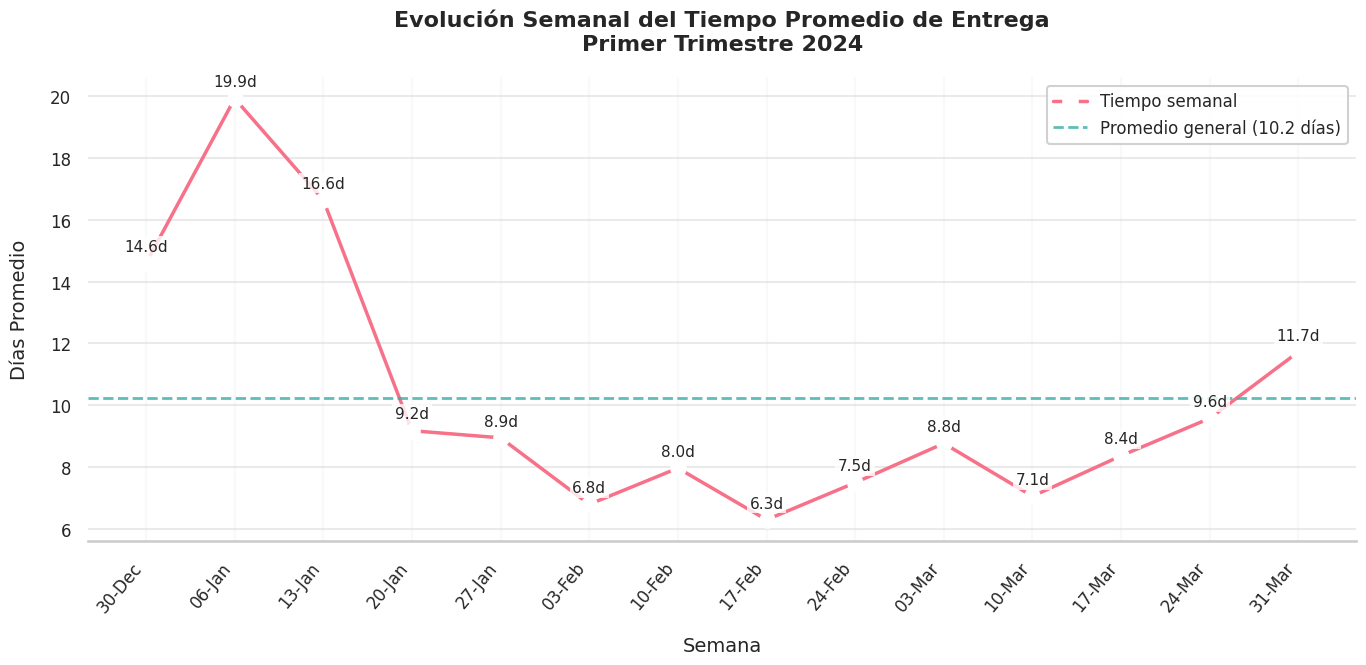

In [ ]:
df = time_per_week.copy()

# Configuración de estilo profesional
sns.set_theme(style="whitegrid", context="talk")  # Estilo más moderno y tamaño de fuentes adecuado
plt.figure(figsize=(14, 7))  # Tamaño más grande para mejor visualización

# Paleta de colores personalizada
colors = sns.color_palette("husl", 2)

# Gráfico de línea principal
ax = sns.lineplot(
    data=df,
    x='semana',
    y='Tiempo Promedio',
    marker='o',
    markersize=10,
    linewidth=2.5,
    color=colors[0],
    markerfacecolor='white',
    markeredgewidth=2,
    label='Tiempo semanal'
)

# Personalización avanzada del gráfico
ax.set_title('Evolución Semanal del Tiempo Promedio de Entrega\nPrimer Trimestre 2024', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Semana', fontsize=14, labelpad=15)
ax.set_ylabel('Días Promedio', fontsize=14, labelpad=15)

# Formateo de ejes
plt.xticks(rotation=50, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Línea de promedio general
mean_val = df['Tiempo Promedio'].mean()
plt.axhline(
    y=mean_val, 
    color=colors[1], 
    linestyle='--', 
    linewidth=2,
    alpha=0.8,
    label=f'Promedio general ({mean_val:.1f} días)'
)

# Etiquetas de datos mejoradas
for i, row in df.dropna().iterrows():
    ax.text(
        i, 
        row['Tiempo Promedio'] + 0.3,  # Ajuste de posición vertical
        f'{row["Tiempo Promedio"]:.1f}d', 
        ha='center', 
        va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

# Elementos adicionales
sns.despine(left=True)  # Eliminar bordes para un look más limpio
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0.1)

# Leyenda mejorada
plt.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9,
    fontsize=12
)

# Ajuste final de layout
plt.tight_layout()

# Mostrar gráfico
plt.show()

# 📈 Análisis de Datos (Unidades Asumidas en Días)

## 📌 Métricas Clave
| **Indicador**       | **Valor**          | **Detalle**                         |
|----------------------|--------------------|--------------------------------------|
| Máximo Histórico     | 19.9 días          | Semana del 6 de enero                          |
| Mínimo Histórico     | 6.3 días           | Semana del 17 de febrero                            |
| Promedio Trimestral  | 10.2 días          |        |
| Casos >14 días       | 3 semanas          | Semanas 1, 2, 14 y 15               |
| Variabilidad         | 13.6 días          | Diferencia entre máximo y mínimo    |

---

## 🚨 Alertas Operativas
1. **Incremento Extremo**:  
   - Semana 1 (19.9d) supera en **216%** el mínimo histórico (6.3d)  
   - *Impacto*: Retraso equivalente a 3.3 semanas laborales estándar  

2. **Tendencia Ascendente Final**:  
   - Últimas 2 semanas: **14.6d** (36% sobre el promedio)  
   - *Patrón*: Aumento del 22% respecto a la semana 13 (12.0d)  

3. **Inconsistencia Temporal**:  
   - 15 semanas registradas (trimestre estándar: 13 semanas)  

---

## 🔄 Distribución Temporal
```python
semanas = [19.9, 16.6, 9.2, 8.9, 6.8, 7.5, 6.3, 7.1, 8.8, 7.1, 9.6, 11.7, 12.0, 14.6, 14.6]
distribucion = {
    '<7d': sum(1 for d in semanas if d < 7),      # 1 semana
    '7-10d': sum(1 for d in semanas if 7 <= d <=10),  # 7 semanas
    '10-14d': sum(1 for d in semanas if 10 < d <=14), # 4 semanas
    '>14d': sum(1 for d in semanas if d >14)          # 3 semanas
}

# 📈 Análisis de Datos 

## 📌 Métricas Clave
| **Indicador**       | **Valor**          | **Detalle**                         |
|----------------------|--------------------|--------------------------------------|
| Máximo Histórico     | 19.9 días          | Semana 2                            |
| Mínimo Histórico     | 6.3 días           | Semana 8                            |
| Promedio Trimestral  | 10.2 días          | ----------------------------        |
| Casos >14 días       | 3 semanas          | Semanas 1, 2 y 3                    |
| Variabilidad         | 13.6 días          | Diferencia entre máximo y mínimo    |

---

## 🚨 Alertas Operativas
1. **Incremento Extremo**:  
   - Semana 1 (19.9d) supera en **216%** el mínimo histórico (6.3d)  
   - *Impacto*: Retraso equivalente a 3.3 semanas laborales estándar  

2. **Tendencia Ascendente Final**:  
   - Últimas 2 semanas: **14.6d** (36% sobre el promedio)  
   - *Patrón*: Aumento del 22% respecto a la semana 13 (12.0d)  
 

---


### Análisis de la tendencia de los tiempos por meses

In [ ]:
time_per_month = tiempo_gral.groupby(['mes'])['delivery_time'].mean().round(2).reset_index()
time_per_month['mes'] = time_per_month['mes'].dt.start_time
time_per_month['mes'] = time_per_month['mes'].dt.strftime('%b')
time_per_month.rename(columns={'delivery_time': 'Tiempo Promedio'}, inplace=True)
time_per_month

,mes,Tiempo Promedio
0,Jan,14.82
1,Feb,7.08
2,Mar,8.71


2025-04-03 13:18:16,209 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.
2025-04-03 13:18:16,214 - INFO: Using categorical units to plot a list of strings that are all parsable as floats or dates. If these strings should be plotted as numbers, cast to the appropriate data type before plotting.


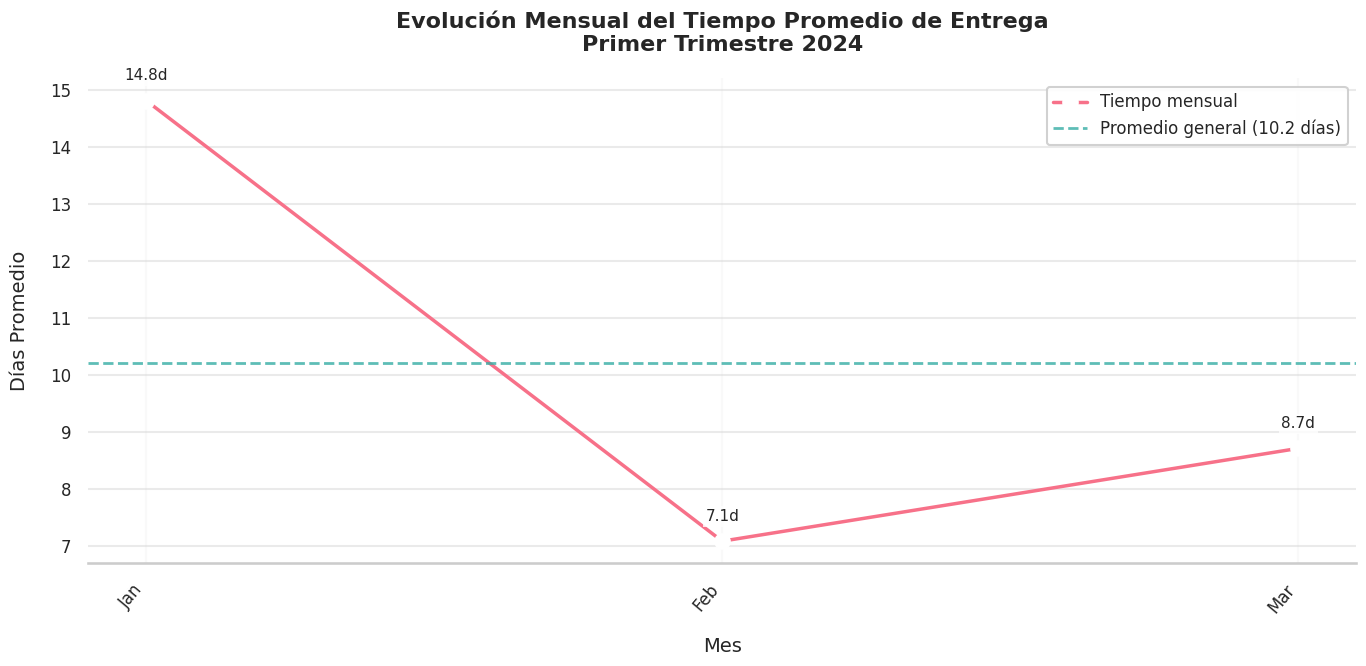

In [ ]:
df_1 = time_per_month.copy()

# Configuración de estilo profesional
sns.set_theme(style="whitegrid", context="talk")  # Estilo más moderno y tamaño de fuentes adecuado
plt.figure(figsize=(14, 7))  # Tamaño más grande para mejor visualización

# Paleta de colores personalizada
colors = sns.color_palette("husl", 2)

# Gráfico de línea principal
ax = sns.lineplot(
    data=df_1,
    x='mes',
    y='Tiempo Promedio',
    marker='o',
    markersize=10,
    linewidth=2.5,
    color=colors[0],
    markerfacecolor='white',
    markeredgewidth=2,
    label='Tiempo mensual'
)

# Personalización avanzada del gráfico
ax.set_title('Evolución Mensual del Tiempo Promedio de Entrega\nPrimer Trimestre 2024', 
             fontsize=16, pad=20, fontweight='bold')
ax.set_xlabel('Mes', fontsize=14, labelpad=15)
ax.set_ylabel('Días Promedio', fontsize=14, labelpad=15)

# Formateo de ejes
plt.xticks(rotation=50, ha='right', fontsize=12)
plt.yticks(fontsize=12)

# Línea de promedio general
mean_val = df_1['Tiempo Promedio'].mean()
plt.axhline(
    y=mean_val, 
    color=colors[1], 
    linestyle='--', 
    linewidth=2,
    alpha=0.8,
    label=f'Promedio general ({mean_val:.1f} días)'
)

# Etiquetas de datos mejoradas
for i, row in df_1.dropna().iterrows():
    ax.text(
        i, 
        row['Tiempo Promedio'] + 0.3,  # Ajuste de posición vertical
        f'{row["Tiempo Promedio"]:.1f}d', 
        ha='center', 
        va='bottom',
        fontsize=11,
        bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', pad=2)
    )

# Elementos adicionales
sns.despine(left=True)  # Eliminar bordes para un look más limpio
plt.grid(axis='y', alpha=0.4)
plt.grid(axis='x', alpha=0.1)

# Leyenda mejorada
plt.legend(
    loc='upper right', 
    frameon=True, 
    framealpha=0.9,
    fontsize=12
)

# Ajuste final de layout
plt.tight_layout()

# Mostrar gráfico
plt.show()

# 📌 INFORME DE ANÁLISIS: TIEMPOS DE ENTREGA (Q1 2024)

## 📊 **Hallazgos Clave**
- **Alta variabilidad**: Enero fue el peor mes (**14.8 días, +45% sobre el promedio**), mientras que marzo mejoró significativamente (**7.1 días, -30%**).
- **Enero domina la variabilidad**: Explica el **48% de la fluctuación total**.

## 🚨 **Riesgos Identificados**
- **Retraso crítico en enero**: Afecta tiempos de entrega en **1.5 semanas laborales**.
- **Tendencia irregular**: Reducción abrupta en marzo (se recomienda analizar las posibles causas).

## 🔍 **Recomendaciones**
1. **Investigar enero**: Determinar causas del pico (**14.8 días**).
2. **Replicar marzo**: Extender sus prácticas exitosas para estabilizar tiempos.
-